# Comparaison des données OSM avec les données de l'IGN

Amélie Joret, Saïd Khatir, Antoine Le Doeuff, Antoine Soumet (Master SIGAT (Rennes 2), promotion 2023-2024).

## Présentation de l'outil

Ce notebook présente une méthode de comparaison entre des données issues d'OSM et de la BD Topo appliquée en python. L'objectif de cet outil est de permettre à l'utilisateur de comparer sur la base de plusieurs indicateurs les deux sources de données.

L'outil est articulé autour de la géométrie des données sources. Pour chaque type de géométrie (point, ligne, polygone), une analyse attributaire puis une brève analyse spatiale est proposée.



## Installation et chargement des modules

Installation :

In [1]:
!pip install geojson
!pip install overpass
# Install mapclassify (cartographie thématique)
!pip install mapclassify
# Instal contextily (fonds de carte)
!pip install contextily
!pip install matplotlib_scalebar

ERROR: Operation cancelled by user
  Using cached geojson-3.1.0-py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 44.6 MB/s eta 0:00:00


Chargement des modules :

In [ ]:
import sys
import re
import time

import requests
import numpy as np
import geopandas as gpd
import pandas as pd
import geojson
import overpass
from overpass.errors import UnknownOverpassError
from shapely.geometry import Polygon
from warnings import warn
import matplotlib.pyplot as plt
import contextily as ctx # Fonds de carte
import seaborn as sb # Graphique
from matplotlib_scalebar.scalebar import ScaleBar
from functools import wraps

## Import des couches 🚚

L'import des données OSM se fait via l'API [overpass](https://wiki.openstreetmap.org/wiki/Overpass_API) au moyen du module python [overpass](https://github.com/mvexel/overpass-api-python-wrapper). Les données de l'IGN sont importées via flux WFS pour les données de la BDTopo. Les sections cadastrales et les communes sont chargées depuis le [cadastre ETALAB](https://cadastre.data.gouv.fr/datasets/cadastre-etalab).

### Définition des constantes 📚

Afin de garantir la lisibilité du code et sa maintenance les paramètres globaux utilisés pour l'import des données sont définis dans des listes et des dictionnaires.

La liste `THEME` enregistre les thèmes disponibles dans l'outil, actuellement : les points de vue (points), les bars et restaurants (points), les parkings (polygone) et les haies (lignes).

In [ ]:
# Thèmes disponibles
THEMES = [
  "view_point",
  "parkings",
  "hedge",
  "bar_resto", # ERP BDTOPO, données incomplètes (tous les départements n'ont pas de données)
]

Les *endpoints* des API sont stockés dans de variables

In [ ]:
# WFS service de l'IGN endpoint
URL_OWS = "https://data.geopf.fr/wfs/ows?"

# URL de l'API Carto du Cadastre
CADASTRE_ETALAB_ENDPOINT = "https://cadastre.data.gouv.fr/bundler/cadastre-etalab"

Les paramètres nécessaires à la construction des requêtes au service WFS de l'IGN sont stockés dans trois dictionnaires :    

- `WFS_PARAMS` défini les paramètres globaux
- `IGN_NAMES` défini le nom des couches à interroger
- `IGN_QUERIES` enregistre les filtres CQL

In [ ]:
# Paramètres de base WFS pour l'IGN
WFS_PARAMS = dict(
  SERVICE="WFS",
  VERSION="2.0.0",
  REQUEST="GetFeature",
  OUTPUTFORMAT="json",
)

# Noms IGN des couches
IGN_NAMES = dict(
  view_point="BDTOPO_V3:zone_d_activite_ou_d_interet",
  parkings="BDTOPO_V3:equipement_de_transport",
  hedge="BDTOPO_V3:haie",
  bar_resto="BDTOPO_V3:erp",
)

# Dictionnaire des requêtes (IGN)
IGN_QUERIES = dict(
  view_point="nature = 'Point de vue' AND WITHIN(geometrie, {})",
  parkings="nature = 'Parking' AND WITHIN(geometrie, {})",
  hedge="WITHIN(geometrie, {})",
  # Insee com dispo dans l'attribut (testé avec geom et pas de diff)
  bar_resto="type_principal IN ('N', 'NALT', 'PN') AND insee_commune='{}'"
)

Les requêtes overpass sont égalements intrégrées à un dictionnaire.

In [ ]:
OSM_QUERIES = dict(
  view_point='(area["ref:INSEE"="{}"];)->.com;node["tourism"="viewpoint"](area.com);',
  parkings='(area["ref:INSEE"="{}"];)->.com;way["amenity"="parking"](area.com);',
  hedge='(area["ref:INSEE"="{}"];)->.com;way["barrier"~"hedge|hedge_bank"](area.com);',
  bar_resto='(area["ref:INSEE"="{}"];)->.com;node["amenity"~"bar|restaurant"](area.com);',
)

Dans les dictionnaires enregistrant les requêtes overpass (`OSM_QUERIES`) et celui contenant les filtres CQL (`IGN_QUERIES`), les accolades servent à indiquer l'endroit où une valeur sera ajoutée a posteriori (requête préparée).

### Définition des fonctions ⚙️

Une fois les constantes définies, des fonctions permettant l'import des données sont définies.

Un décorateur (`@timeit`) est défini pour calculer le temps nécessaire à l'import des données, il est appliqué aux fonctions `get_osm()` et `get_bdtopo()` définies plus bas.

In [ ]:
def timeit(func):
  @wraps(func)
  def timeit_wrapper(*args, **kwargs):
    start_time = time.perf_counter()
    result = func(*args, **kwargs)
    end_time = time.perf_counter()
    total_time = end_time - start_time
    print(f'[Execution time: {total_time:.4f} seconds]')
    return result
  return timeit_wrapper

#### Import des données de l'IGN

Les données de la BDTopo ne contiennent pas toutes des identifiants de localisation des entités (par ex. le code INSEE). Il n'est donc pas possible de filtrer ces données directement sur un champ d'identifiant de localisation. Par ailleurs, en raison de la limite de taille de l'url, il n'est pas possible d'intégrer un filtre spatiale à l'aide du polygone / multi polygone de la commune. Aussi, la méthode employée pour récupérer les données de la BDTopo est la suivante :    

1. Récupération de la commune via le cadastre ETALAB au moyen du code INSEE fourni par l'utilisateur
2. Calcul de la bbox associée à la commune
3. Interrogation du service WFS via une filtre spatial (`WHITHIN`) au moyen de la bbox
4. Intersection des données avec la commune

Cette méthode est loin d'être performante dans la mesure où le nombre d'opération est quatre fois plus important que s'il existait une information de localisation dans les données de la BDTopo, comme c'est le cas avec les données OSM.

La récupération de la commune via le cadastre ETALAB, se fait au moyen de la fonction `get_cadastre()`. Cette dernière construit la requête pour récupérer la donnée sur la base du code INSEE, récupère le jeu de donnée et le converti et `GeoDataFrame`.

In [ ]:
def get_cadastre(
  code_insee:int,
  scale:str,
) -> gpd.GeoDataFrame:
  if scale not in (ref_scale := ["communes", "sections", "parcelles"]):
    raise ValueError(f"{scale} n'est pas reconnu. Valeurs possibles : {ref_scale}")

  # créer l'URL
  url_com = f"{CADASTRE_ETALAB_ENDPOINT}/communes/{code_insee}/geojson/{scale}"

  # Récupérer les données
  com_r = requests.get(url_com)

  # Transformer en gpd.GeoDataFrame
  cadastre = gpd.GeoDataFrame.from_features(
    geojson.loads(com_r.content),
    crs="EPSG:4326",
  )
  return cadastre

Le calcul de la bbox est réalisé au moyen de la fonction `get_bbox()` qui s'appuie sur la fonction `invert_coords()` dont l'objectif est d'intervertir latitude et longitude dans une instance de classe `shapely.geometry.Polygon`. Cette interversion est nécessaire dans la mesure où le service WFS requiert que le polygon passé dans le filtre spatial soit formaté selon `(y,x)`, ce qui n'est pas le cas du polygon de la bbox obtenu au moyen de la propriété `enveloppe` de `GeoPandas`. La bbox retournée par la fonction `get_bbox()` est une chaîne de caractères formatée de telle sorte à ce qu'elle soit lisible par le service WFS de l'IGN.

In [ ]:
def invert_coords(geom:Polygon) -> Polygon:
  coords = list(geom.exterior.coords)
  coords = [(y,x) for x,y in coords]
  return Polygon(coords)


def get_bbox(data:gpd.GeoDataFrame) -> str:
  bbox = data.envelope[0]
  bbox = str(invert_coords(bbox))
  bbox = bbox.replace("POLYGON ((", "Polygon((")
  return bbox

Les données de la BDTopo sont récupérées au moyen de la fonction `get_bdtopo()`, elle effectue les opérations suivantes :     

1. Évaluation du thème passé par l'utilisateur
2. Récupération de la bbox
3. construction de la requête WFS
4. Récupération de la donnée (s'effectue à l'aide de la fonction `fetch_wfs()`)
5. Intersection de la donnée avec la commune
6. Si le thème point de vue est sélectionné, calcul du centroïde des points de vue

In [ ]:
def fetch_wfs(endpoint:str, params:dict) -> (requests.Response | None):
  try:
    r = requests.get(endpoint, params=params)
    r.raise_for_status()  # Déclencher une HTTPError pour les codes de statut incorrects
  except RequestException as e:
    # Attraper RequestException pour gérer les problèmes liés au serveur
    warn(f"Erreur du serveur: {e}")
    return None
  except Exception as e:
    # Attraper d'autres exceptions
    warn(f"Erreur: {e}")
    return None
  return r


@timeit
def get_bdtopo(
  theme:str,
  code_insee:int,
) -> (gpd.GeoDataFrame | pd.DataFrame | pd.Series | None):
  if theme not in THEMES:
    raise ValueError("The provided theme is not available")

  # Calculer la boîte englobante
  com = get_cadastre(code_insee, "communes")
  bbox = get_bbox(com)

  # Obtenir les paramètres
  params = WFS_PARAMS
  params["TYPENAME"] = IGN_NAMES[theme]
  params["cql_filter"] = IGN_QUERIES[theme]

  # Définir la zone de délimitation dans la requête
  if theme == 'bar_resto':
    params["cql_filter"] = re.sub("{}", str(code_insee), params["cql_filter"])
  else:
    params["cql_filter"] = re.sub("{}", bbox, params["cql_filter"])

  # Récupérer les données
  r = fetch_wfs(URL_OWS, params)

  # Tester le nombre de valeurs retournées
  if r:
    r_json = r.json()
    if r_json.get('totalFeatures') == 0:
      warn("No entity was found")
      return None
    else:
      # Convertir les données en GeoDataFrame
      raw = gpd.GeoDataFrame.from_features(
        geojson.loads(r.content),
        crs="EPSG:4326",
      )
  else:
    warn("No entity was found")
    return None

  # Récupérer les données qui intersectent la commune
  if theme != "bar_resto":
    data = raw.overlay(com, how="intersection")
  else:
    data = raw.copy()

  # Pour le thème des points de vue, calculer les centroïdes
  if theme == "view_point":
    data.geometry = data.centroid

  return data

Les données OSM sont quant-à-elles récupérées au moyen de la fonction `get_osm()`. Cette dernière s'appuie sur la fonction `line_string_to_pol()` qui convertit les géométries d'une lineString, dont le premier et le dernier noeud est similaire, en polygon. En effet, dans OSM, de nombreuses données qui sont généralement modélisés sous la forme de polygone le sont aux moyens de *ways* qui ont pour objectif de modéliser des formes polygonales comme des parkings.

In [ ]:
def line_string_to_pol(
  gjson:geojson.FeatureCollection,
) -> geojson.FeatureCollection:
  converted = gjson
  for f in converted.features:
    if f.geometry.type == "LineString":
      f.geometry.type = "Polygon"
      f.geometry.coordinates = [f.geometry.coordinates]
  return converted

La fonction `get_osm()` réalise les opérations suivantes :    

1. Évaluation thème passé par l'utilisateur
2. instantiation d'un class `overpass.API` avec un timeout défini par défaut (60 sec) ou défini par l'utilisateur.
3. Construction de la requête overpass
4. Récupération de la donnée
5. Évaluation du nombre de géométrie retournée, si 0, retourner un exception
6. Si la donnée doit être retournée sous forme de polygone (par ex. parkings), utilisation de la fonction `line_string_to_pol()`
7. Conversion de la donnée en `GeoDataFrame`

In [ ]:
@timeit
def get_osm(
  theme:str,
  code_insee:int,
  timeout:int=60,
) -> (gpd.GeoDataFrame | None):
  if theme not in THEMES:
    raise ValueError("The provided theme is not available")

  # Instancier la classe avec un délai de 60 secondes
  api = overpass.API(timeout=timeout)

  # récupérer la requête
  query = OSM_QUERIES[theme]
  # Définir le code_insee
  query = re.sub("{}", str(code_insee), query)

  # Récupérer des données (renvoie du geojson)
  try:
    if theme in ["parkings", "hedge"]:
      r = api.get(query, verbosity="geom")
    else:
      r = api.get(query)
  except UnknownOverpassError as e:
    warn(f"Overpass error : {e}")
    return None

  if len(r.features) == 0:
    warn("No entity was found")
    return None

  # Si le thème correspond à celui des parkings, convertir les LineString en
  # Polygon
  if theme == "parkings":
    r = line_string_to_pol(r)

  # Convertie en GeoDataFrame
  data = gpd.GeoDataFrame.from_features(r, crs="EPSG:4326",)

  return data

Au final, pour récupérer les données d'OSM et de la BDTopo pour un thème et un code INSEE donné, il suffit d'entrer les lignes suivantes :    


In [ ]:
# Définir les paramètres
code_insee = 29195
theme = "parkings"

# Récupérer la donnée
print("Fetching IGN data...")
data_bdtopo = get_bdtopo(theme=theme, code_insee=code_insee)
print("Fetching OSM data...")
data_osm = get_osm(theme=theme, code_insee=code_insee)

Fetching IGN data...
[Execution time: 4.1562 seconds]
Fetching OSM data...
[Execution time: 1.1476 seconds]


## 1. Points : exemple des bars et restaurants 🍷

Récupération des données des bars et restaurants. Il vous est loisible de changer la valeur des variables `code_insee` et `name`.

In [ ]:
# Define parameters
code_insee = 29019
name = "bar_resto"

# Fetch data
print("Fetching IGN data...")
data_bdtopo = get_bdtopo(theme=name, code_insee=code_insee)
print("Fetching OSM data...")
data_osm = get_osm(theme=name, code_insee=code_insee)
data_osm.plot

Fetching IGN data...
[Execution time: 2.5718 seconds]
Fetching OSM data...
[Execution time: 1.1681 seconds]


En premier lieu nous allons voir la répartition spatiale visuelle des points de chaque jeu de données

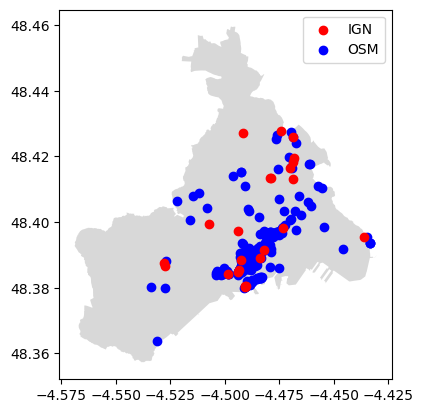

In [ ]:
# Afficher la localisation des bars et restos entre les deux bases

com = get_cadastre(code_insee, "communes")

_, ax = plt.subplots(nrows=1, ncols=1)
com.plot(ax=ax, color="Grey", alpha=0.3, zorder = 1)
data_bdtopo.plot(ax=ax, color="Red", label="IGN", zorder = 3)
data_osm.plot(ax=ax, color="Blue", label="OSM", zorder = 2)
plt.legend()
plt.show()

data_osm.to_file("PV_osm", layer='data_osm', driver="GPKG")
data_bdtopo.to_file("PV_bdtopo", layer='data_bdtopo', driver='GPKG')

barResto_osm = data_osm
barResto_bdtopo = data_bdtopo

In [ ]:
# Mesurer la taille (arrondi) de la liste en mémoire
#OSM
taille = sys.getsizeof(barResto_osm)
print("Taille du fichier haies en mémoire depuis OSM :", round(taille/1048576,2), "Mo")

#BD TOPO
taille = sys.getsizeof(barResto_bdtopo)
print("Taille du fichier haies en mémoire depuis la BD TOPO :", round(taille/1048576,2), "Mo")

Taille du fichier haies en mémoire depuis OSM : 0.76 Mo
Taille du fichier haies en mémoire depuis la BD TOPO : 0.03 Mo


### Analyse attributaire 📈

On va regarder ce que comporte l'intérieur des tables

In [ ]:
#Checker les types des champs de la couche point de vue de la BDTOPO
barResto_bdtopo.dtypes

geometry                               geometry
cleabs                                   object
id_reference                             object
categorie                                object
type_principal                           object
types_secondaires                        object
activite_principale                      object
activites_secondaires                    object
libelle                                  object
etat_de_l_objet                          object
date_creation                            object
date_modification                        object
date_d_apparition                        object
date_de_confirmation                     object
sources                                  object
identifiants_sources                     object
methode_d_acquisition_planimetrique      object
precision_planimetrique                   int64
public                                     bool
ouvert                                     bool
capacite_d_accueil_du_public            

In [ ]:
#Checker les types des champs de la couche point de vue de la base OSM
barResto_osm.dtypes

geometry             geometry
amenity                object
name                   object
ref:FR:SIRET           object
source                 object
                       ...   
contact:instagram      object
start_date             object
craft                  object
branch                 object
website:menu           object
Length: 99, dtype: object

On va comparer le nombre d'entités dans chaque base

In [ ]:
# Ajouter un nouveau champ ID
barResto_bdtopo['ID'] = barResto_bdtopo.index
barResto_osm['ID'] = barResto_osm.index

# Calculer le nombre de points de vue dans la commune dans la base OSM
total_rows_bdtopo = barResto_bdtopo["ID"].size

# Afficher le résultat
print("Le nombre de bars et restos dans la commune dans la BDTOPO est de :", total_rows_bdtopo)

# Calculer le nombre de points de vue dans la commune dans la base OSM
total_rows_osm = barResto_osm["ID"].size

# Afficher le résultat
print("Le nombre de bars et restos dans la commune dans la base OSM est de :", total_rows_osm)

Le nombre de bars et restos dans la commune dans la BDTOPO est de : 24
Le nombre de bars et restos dans la commune dans la base OSM est de : 236


On va calculer le taux de remplissage des tables de chaque jeu de données

Table OSM 🔎

In [ ]:
# Calculer le taux de remplissage des attributs pour chaque colonne
fill_rates = {column: (barResto_osm[column].notna().sum() / total_rows_osm) * 100 for column in barResto_osm.columns}

# Trier les taux de remplissage par ordre croissant
sorted_fill_rates = sorted(fill_rates.items(), key=lambda x: x[1], reverse=True)

# Calculer le taux de remplissage total
total_non_null = sum(barResto_osm[column].notna().sum() for column in barResto_osm.columns)
total_fill_rate = (total_non_null / (total_rows_osm * len(fill_rates))) * 100

# Afficher le taux de remplissage total en première ligne en gras
print(f"\033[1mLe taux de remplissage total est des attributs est de {total_fill_rate:.2f}%\033[0m")

# Afficher les taux de remplissage pour chaque colonne par ordre croissant
for column, fill_rate in sorted_fill_rates:
    print(f"'{column}' est de {fill_rate:.2f}%")


Le taux de remplissage total est des attributs est de 8.08%
'geometry' est de 100.00%
'amenity' est de 100.00%
'name' est de 100.00%
'ID' est de 100.00%
'cuisine' est de 46.19%
'addr:street' est de 27.97%
'website' est de 26.27%
'opening_hours' est de 25.85%
'addr:postcode' est de 24.15%
'addr:city' est de 23.73%
'addr:housenumber' est de 23.73%
'wheelchair' est de 22.03%
'phone' est de 21.61%
'ref:FR:SIRET' est de 19.07%
'contact:phone' est de 12.29%
'check_date' est de 11.44%
'outdoor_seating' est de 9.32%
'contact:email' est de 9.32%
'takeaway' est de 8.47%
'smoking' est de 5.93%
'diet:vegetarian' est de 4.66%
'contact:street' est de 4.24%
'old_name' est de 3.81%
'brewery' est de 3.81%
'contact:housenumber' est de 3.81%
'source' est de 3.39%
'contact:facebook' est de 3.39%
'contact:city' est de 2.97%
'delivery' est de 2.54%
'level' est de 2.54%
'contact:postcode' est de 2.54%
'tobacco' est de 2.54%
'toilets:wheelchair' est de 2.12%
'indoor_seating' est de 1.69%
'contact:website' est

Table BDTOPO 🧭

In [ ]:
# Calculer le taux de remplissage des attributs pour chaque colonne
fill_rates = {column: (barResto_bdtopo[column].notna().sum() / total_rows_bdtopo) * 100 for column in barResto_bdtopo.columns}

# Trier les taux de remplissage par ordre croissant
sorted_fill_rates = sorted(fill_rates.items(), key=lambda x: x[1], reverse = True)

# Calculer le taux de remplissage total
total_non_null = sum(barResto_bdtopo[column].notna().sum() for column in barResto_bdtopo.columns)
total_fill_rate = (total_non_null / (total_rows_bdtopo * len(fill_rates))) * 100

# Afficher le taux de remplissage total en première ligne en gras
print(f"\033[1mLe taux de remplissage total des attributs est de {total_fill_rate:.2f}%\033[0m")

# Afficher les taux de remplissage pour chaque colonne par ordre croissant
for column, fill_rate in sorted_fill_rates:
    print(f"'{column}' est de {fill_rate:.2f}%")

Le taux de remplissage total des attributs est de 57.64%
'geometry' est de 100.00%
'cleabs' est de 100.00%
'type_principal' est de 100.00%
'libelle' est de 100.00%
'etat_de_l_objet' est de 100.00%
'date_creation' est de 100.00%
'sources' est de 100.00%
'identifiants_sources' est de 100.00%
'methode_d_acquisition_planimetrique' est de 100.00%
'precision_planimetrique' est de 100.00%
'public' est de 100.00%
'ouvert' est de 100.00%
'origine_de_la_geometrie' est de 100.00%
'validation_ign' est de 100.00%
'insee_commune' est de 100.00%
'adresse_nom_1' est de 100.00%
'code_postal' est de 100.00%
'ID' est de 100.00%
'activite_principale' est de 95.83%
'capacite_d_accueil_du_public' est de 95.83%
'categorie' est de 79.17%
'date_modification' est de 4.17%
'id_reference' est de 0.00%
'types_secondaires' est de 0.00%
'activites_secondaires' est de 0.00%
'date_d_apparition' est de 0.00%
'date_de_confirmation' est de 0.00%
'capacite_d_hebergement' est de 0.00%
'type_de_localisation' est de 0.00%
'n

Calculer la proportion des bars et restaurants entre les deux jeux de données

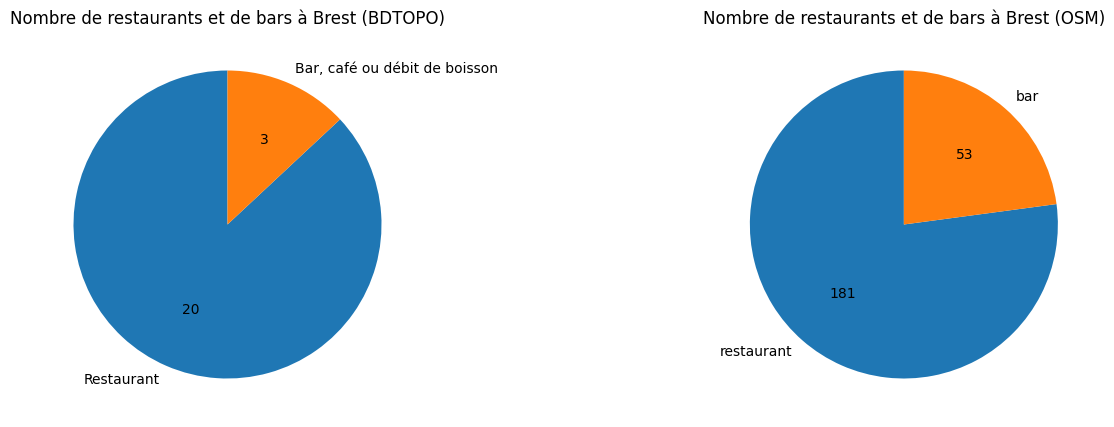

In [ ]:
# Créer une figure et des sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Pi chart pour 'activite_principale' de 'barResto_bdtopo'
activite_counts = barResto_bdtopo['activite_principale'].value_counts()
activite_counts.plot.pie(ax=axs[0], autopct=lambda x: f'{int(x / 100 * len(barResto_bdtopo))}', startangle=90)
axs[0].set_title('Nombre de restaurants et de bars à Brest (BDTOPO)')
axs[0].set_ylabel('')  # Supprimer l'étiquette de l'axe y
axs[0].legend().set_visible(False)  # Supprimer la légende

# Pi chart pour 'amenity' de 'barResto_osm'
amenity_counts = barResto_osm['amenity'].value_counts()
amenity_counts.plot.pie(ax=axs[1], autopct=lambda x: f'{int(x / 100 * len(barResto_osm))}', startangle=90)
axs[1].set_title('Nombre de restaurants et de bars à Brest (OSM)')
axs[1].set_ylabel('')  # Supprimer l'étiquette de l'axe y
axs[1].legend().set_visible(False)  # Supprimer la légende

plt.show()

 ### Analyse spatiale 🌎

In [ ]:
# Reprojeter la couche en 2154
barResto_osm_2154 = barResto_osm.to_crs(2154)
barResto_bdtopo_2154 = barResto_bdtopo.to_crs(2154)
com_ok = com.to_crs(2154)

geometry          id commune  \
0  MULTIPOLYGON (((145458.201 6843785.646, 145418...  290190000A   29019   
1  MULTIPOLYGON (((145576.130 6838607.328, 145553...  29019000AB   29019   
2  MULTIPOLYGON (((145084.056 6837820.610, 145091...  29019000AC   29019   

  prefixe code     created     updated  
0     000    A  2002-05-17  2014-03-26  
1     000   AB  2002-03-28  2022-12-26  
2     000   AC  2002-03-28  2022-12-26

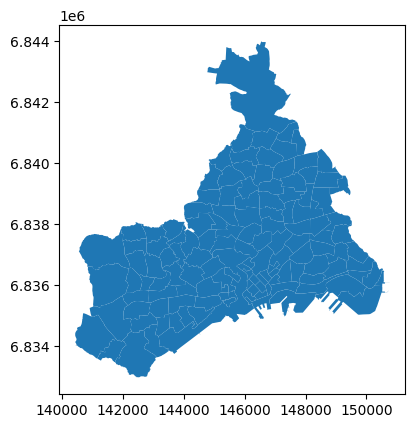

In [ ]:
# Import des sections cadastrales

sections_commune = get_cadastre(code_insee, "sections")
sections_commune = sections_commune.to_crs(2154)
sections_commune.plot()
sections_commune.head(3)

In [ ]:
# Effectuer une jointure spatiale entre les points géolocalisés et les sections pour la base OSM
barResto_osm_sections1 = gpd.sjoin(barResto_osm_2154, sections_commune, how='left', predicate='intersects')

# Compter le nombre de points géolocalisés par section
nombre_points_par_section1 = barResto_osm_sections1.groupby('id').size().reset_index(name='nombre_points')

# Fusionner les informations du nombre de points géolocalisés avec les sections
sections_commune1 = sections_commune.merge(nombre_points_par_section1, on='id', how='left')


In [ ]:
# Effectuer une jointure spatiale entre les points géolocalisés et les sections pour la base BDTOPO
barResto_bdtopo_sections2 = gpd.sjoin(barResto_bdtopo_2154, sections_commune, how='left', predicate='intersects')

# Compter le nombre de points géolocalisés par section
nombre_points_par_section2 = barResto_bdtopo_sections2.groupby('id').size().reset_index(name='nombre_points')

# Fusionner les informations du nombre de points géolocalisés avec les sections
sections_commune2 = sections_commune.merge(nombre_points_par_section2, on='id', how='left')


In [ ]:
# Calculer les centroïdes tout en conservant les attributs
sections_centro1 = sections_commune1.copy()  # Créez une copie de la couche
sections_centro1['geometry'] = sections_commune1.centroid  # Remplacez la géométrie par les centroïdes

# Afficher le DataFrame
print(sections_centro1)


                           geometry          id commune prefixe code  \
0    POINT (146313.035 6842405.988)  290190000A   29019     000    A   
1    POINT (145396.374 6838338.891)  29019000AB   29019     000   AB   
2    POINT (145132.909 6838045.338)  29019000AC   29019     000   AC   
3    POINT (145521.035 6837752.318)  29019000AD   29019     000   AD   
4    POINT (146176.172 6837695.065)  29019000AE   29019     000   AE   
..                              ...         ...     ...     ...  ...   
128  POINT (145371.859 6835860.934)  29019000KW   29019     000   KW   
129  POINT (150474.672 6836154.540)  29019000KX   29019     000   KX   
130  POINT (149805.378 6835475.036)  29019000KY   29019     000   KY   
131  POINT (143640.174 6837839.287)  29019000KZ   29019     000   KZ   
132  POINT (145589.407 6836342.260)  29019000LA   29019     000   LA   

        created     updated  nombre_points  
0    2002-05-17  2014-03-26            NaN  
1    2002-03-28  2022-12-26            NaN  


In [ ]:
# Calculer les centroïdes tout en conservant les attributs
sections_centro2 = sections_commune2.copy()  # Créez une copie de la couche
sections_centro2['geometry'] = sections_commune2.centroid  # Remplacez la géométrie par les centroïdes

# Afficher le DataFrame
print(sections_centro2)


                           geometry          id commune prefixe code  \
0    POINT (146313.035 6842405.988)  290190000A   29019     000    A   
1    POINT (145396.374 6838338.891)  29019000AB   29019     000   AB   
2    POINT (145132.909 6838045.338)  29019000AC   29019     000   AC   
3    POINT (145521.035 6837752.318)  29019000AD   29019     000   AD   
4    POINT (146176.172 6837695.065)  29019000AE   29019     000   AE   
..                              ...         ...     ...     ...  ...   
128  POINT (145371.859 6835860.934)  29019000KW   29019     000   KW   
129  POINT (150474.672 6836154.540)  29019000KX   29019     000   KX   
130  POINT (149805.378 6835475.036)  29019000KY   29019     000   KY   
131  POINT (143640.174 6837839.287)  29019000KZ   29019     000   KZ   
132  POINT (145589.407 6836342.260)  29019000LA   29019     000   LA   

        created     updated  nombre_points  
0    2002-05-17  2014-03-26            NaN  
1    2002-03-28  2022-12-26            NaN  


In [2]:
# Faire la carte choroplèthe
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer les sections avec une couleur basée sur le nombre de points et une taille de marqueur variable
sections_centro1.to_crs('EPSG:3857').plot(ax=ax, markersize=sections_centro1['nombre_points'] * 3, color='green', categorical=False, alpha=1, legend=True, legend_kwds={'title': 'Nombre de bars et restos (OSM) par sections', 'loc': 'upper right', 'title_fontsize': 10, 'fontsize': 8})

# Ajouter les contours des sections
sections_commune1.to_crs('EPSG:3857').plot(ax=ax, color='none', edgecolor='black', linewidth=0.3)

# Ajouter un fond de carte
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)

# Supprimer les axes
ax.axis('off')

# Titre de la carte
plt.title('Nombre de Bars et Restos par section cadastrales', loc='left', fontsize=15)

# Ajouter une échelle
scalebar = ScaleBar(0.2, location='lower right', box_alpha=0, color='grey')  # Ajustez la valeur de l'échelle selon vos besoins
ax.add_artist(scalebar)

# Ajouter les sources
ax.text(0.80, 0.03, 'Sources : Open Street Map', verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='grey', fontsize=7)

# Ajouter un texte pour l'orientation
ax.text(0.05, 0.98, '↑ Nord', ha='center', va='center', fontsize=10, transform=ax.transAxes)

# Afficher la carte
plt.show()


NameError: name 'plt' is not defined

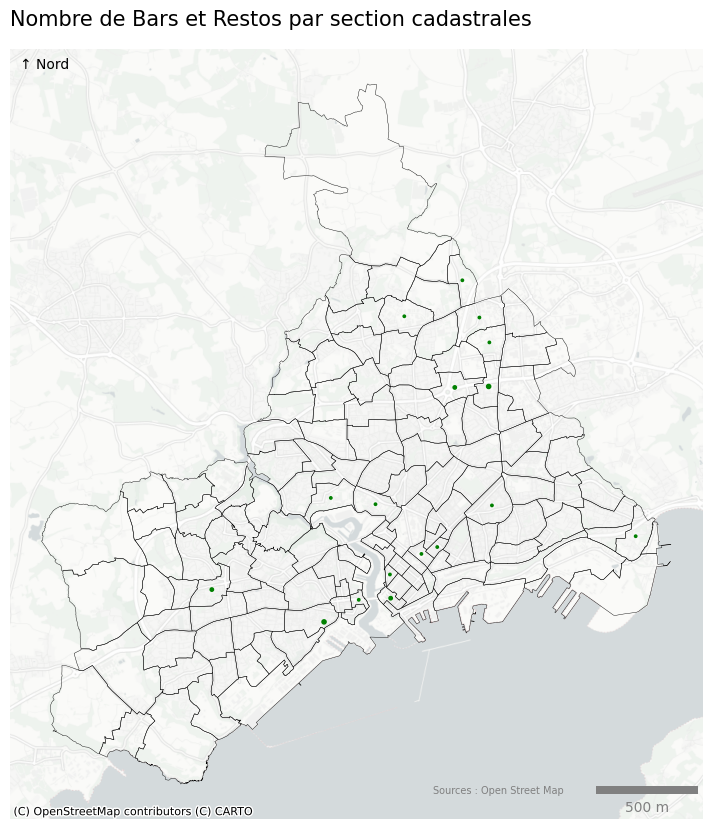

In [ ]:
# Faire la carte choroplèthe
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer les sections avec une couleur basée sur le nombre de points et une taille de marqueur variable
sections_centro2.to_crs('EPSG:3857').plot(ax=ax, markersize=sections_centro2['nombre_points'] * 3, color='green', categorical=False, alpha=1, legend=True, legend_kwds={'title': 'Nombre de bars et restos (BDTOPO) par sections', 'loc': 'upper right', 'title_fontsize': 10, 'fontsize': 8})

# Ajouter les contours des sections
sections_commune2.to_crs('EPSG:3857').plot(ax=ax, color='none', edgecolor='black', linewidth=0.3)

# Ajouter un fond de carte
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)

# Supprimer les axes
ax.axis('off')

# Titre de la carte
plt.title('Nombre de Bars et Restos par section cadastrales', loc='left', fontsize=15)

# Ajouter une échelle
scalebar = ScaleBar(0.2, location='lower right', box_alpha=0, color='grey')  # Ajustez la valeur de l'échelle selon vos besoins
ax.add_artist(scalebar)

# Ajouter les sources
ax.text(0.80, 0.03, 'Sources : Open Street Map', verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='grey', fontsize=7)

# Ajouter un texte pour l'orientation
ax.text(0.05, 0.98, '↑ Nord', ha='center', va='center', fontsize=10, transform=ax.transAxes)

# Afficher la carte
plt.show()


## 2. Lignes : exemple des haies 🌳

### Determination des indicateurs (lignes)

Récupération des données des haies

In [ ]:
# Définir les paramètres
code_insee = 29019
theme = "hedge"

# Récupérer la donnée
print("Fetching IGN data...")
h_data_bdtopo = get_bdtopo(theme=theme, code_insee=code_insee)
print("Fetching OSM data...")
h_data_osm = get_osm(theme=theme, code_insee=code_insee)

Fetching IGN data...
[Execution time: 15.1389 seconds]
Fetching OSM data...
[Execution time: 1.7118 seconds]


En premier lieu nous allons voir la répartition spataile visuelle des lignes de chaque jeu de données

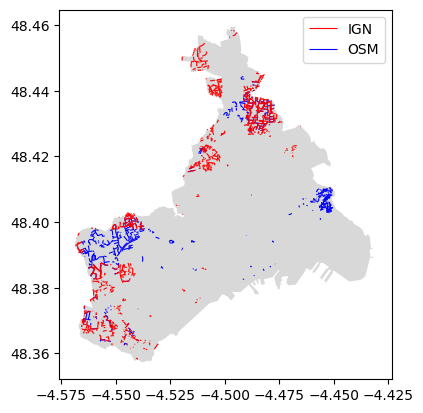

In [ ]:
# Afficher la localisation des haies entre les deux bases

com = get_cadastre(code_insee, "communes")

_, ax = plt.subplots(nrows=1, ncols=1)
com.plot(ax=ax, color="Grey", alpha=0.3, zorder = 1)
h_data_bdtopo.plot(ax=ax, color="Red", label="IGN", zorder = 3, linewidth=0.8)
h_data_osm.plot(ax=ax, color="Blue", label="OSM", zorder = 2, linewidth=0.8)
plt.legend()
plt.show()

h_data_osm.to_file("H_osm", layer='data_osm', driver="GPKG")
h_data_bdtopo.to_file("H_bdtopo", layer='data_bdtopo', driver='GPKG')

H_osm = h_data_osm
H_bdtopo = h_data_bdtopo

In [ ]:
# Mesurer la taille (arrondi) de la liste en mémoire
#OSM
taille = sys.getsizeof(H_osm)
print("Taille du fichier haies en mémoire depuis OSM :", round(taille/1048576,2), "Mo")

#BD TOPO
taille = sys.getsizeof(H_bdtopo)
print("Taille du fichier haies en mémoire depuis la BD TOPO :", round(taille/1048576,2), "Mo")

Taille du fichier haies en mémoire depuis OSM : 0.07 Mo
Taille du fichier haies en mémoire depuis la BD TOPO : 0.94 Mo


### Analyse attributaire 📈

On va regarder ce que comporte l'intérieur des tables

In [ ]:
#Checker les types des champs de la couche haie de la BDTOPO
H_bdtopo.dtypes

cleabs                                   object
date_creation                            object
date_modification                        object
date_d_apparition                        object
date_de_confirmation                     object
hauteur                                  object
largeur                                  object
sources                                  object
identifiants_sources                     object
methode_d_acquisition_planimetrique      object
precision_planimetrique                   int64
id                                       object
nom                                      object
created                                  object
updated                                  object
geometry                               geometry
dtype: object

In [ ]:
#Checker les types des champs de la couche haie de la base OSM
H_osm.dtypes

geometry    geometry
barrier       object
source        object
dtype: object

On va comparer le nombre d'entités dans chaque base

In [ ]:
# Ajouter un nouveau champ ID
H_bdtopo['ID'] = H_bdtopo.index
H_osm['ID'] = H_osm.index

# Calculer le nombre de haies dans la commune dans la base OSM
total_rows_bdtopo = H_bdtopo["ID"].size

# Afficher le résultat
print("Le nombre de lignes de haies dans la commune pour la BDTOPO est de :", total_rows_bdtopo)

# Calculer le nombre de haies dans la commune dans la base OSM
total_rows_osm = H_osm["ID"].size

# Afficher le résultat
print("Le nombrede lignes de haies dans la commune pour la base OSM est de :", total_rows_osm)

Le nombre de lignes de haies dans la commune pour la BDTOPO est de : 1194
Le nombrede lignes de haies dans la commune pour la base OSM est de : 732


On va calculer le taux de remplissage des tables de chaque jeu de données

Table OSM 🔎

In [ ]:
# Calculer le taux de remplissage des attributs pour chaque colonne
fill_rates = {column: (H_osm[column].notna().sum() / total_rows_osm) * 100 for column in H_osm.columns}

# Trier les taux de remplissage par ordre croissant
sorted_fill_rates = sorted(fill_rates.items(), key=lambda x: x[1], reverse=True)

# Calculer le taux de remplissage total
total_non_null = sum(H_osm[column].notna().sum() for column in H_osm.columns)
total_fill_rate = (total_non_null / (total_rows_osm * len(fill_rates))) * 100

# Afficher le taux de remplissage total en première ligne en gras
print(f"\033[1mLe taux de remplissage total est des attributs est de {total_fill_rate:.2f}%\033[0m")

# Afficher les taux de remplissage pour chaque colonne par ordre croissant
for column, fill_rate in sorted_fill_rates:
    print(f"'{column}' est de {fill_rate:.2f}%")

Le taux de remplissage total est des attributs est de 75.03%
'geometry' est de 100.00%
'barrier' est de 100.00%
'ID' est de 100.00%
'source' est de 0.14%


Table BDTOPO 🧭

In [ ]:
# Calculer le taux de remplissage des attributs pour chaque colonne
fill_rates = {column: (H_bdtopo[column].notna().sum() / total_rows_bdtopo) * 100 for column in H_bdtopo.columns}

# Trier les taux de remplissage par ordre croissant
sorted_fill_rates = sorted(fill_rates.items(), key=lambda x: x[1], reverse = True)

# Calculer le taux de remplissage total
total_non_null = sum(H_bdtopo[column].notna().sum() for column in H_bdtopo.columns)
total_fill_rate = (total_non_null / (total_rows_bdtopo * len(fill_rates))) * 100

# Afficher le taux de remplissage total en première ligne en gras
print(f"\033[1mLe taux de remplissage total des attributs est de {total_fill_rate:.2f}%\033[0m")

# Afficher les taux de remplissage pour chaque colonne par ordre croissant
for column, fill_rate in sorted_fill_rates:
    print(f"'{column}' est de {fill_rate:.2f}%")

Le taux de remplissage total des attributs est de 76.11%
'cleabs' est de 100.00%
'date_creation' est de 100.00%
'sources' est de 100.00%
'methode_d_acquisition_planimetrique' est de 100.00%
'precision_planimetrique' est de 100.00%
'id' est de 100.00%
'nom' est de 100.00%
'created' est de 100.00%
'updated' est de 100.00%
'geometry' est de 100.00%
'ID' est de 100.00%
'date_modification' est de 98.99%
'identifiants_sources' est de 94.89%
'date_d_apparition' est de 0.00%
'date_de_confirmation' est de 0.00%
'hauteur' est de 0.00%
'largeur' est de 0.00%


Calculer la longueur des haies dans la communes selon les bases et sortir un histogramme de répartition des longueurs de lignes

Table OSM 🔎

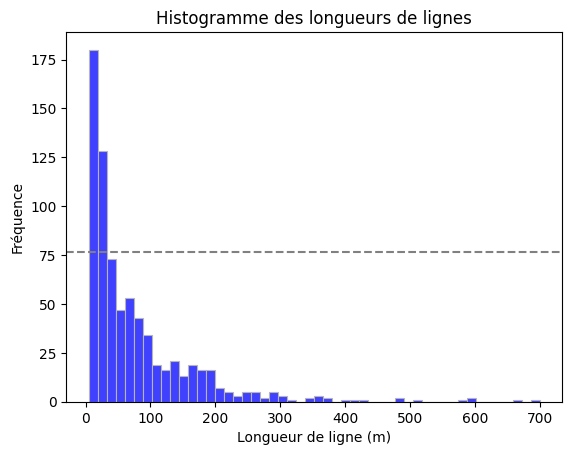

In [ ]:
# Convertir le GeoDataFrame en une projection appropriée pour le calcul de longueur
H_osm2154 = H_osm.to_crs(2154)

# Calculer la longueur de chaque ligne et ajouter le résultat à une nouvelle colonne
H_osm2154 = H_osm2154.assign(longueur=H_osm2154.geometry.length)

# Calculer la somme des longueurs de toutes les lignes
longueur_totale_osm = H_osm2154.longueur.sum()

# Créer un histogramme des longueurs de lignes
sb.histplot(H_osm2154.longueur, bins=50, edgecolor='#b6b6b6', linewidth=0.8, color = 'blue')
plt.xlabel('Longueur de ligne (m)')
plt.ylabel('Fréquence')
plt.title('Histogramme des longueurs de lignes')

# Calculer la moyenne des longueurs de haies
moyenne = H_osm2154['longueur'].mean()

# Ajouter la courbe de la moyenne
plt.axhline(y=moyenne, color='grey', linestyle='--', label='Moyenne')
plt.show()

Table BDTOPO 🧭

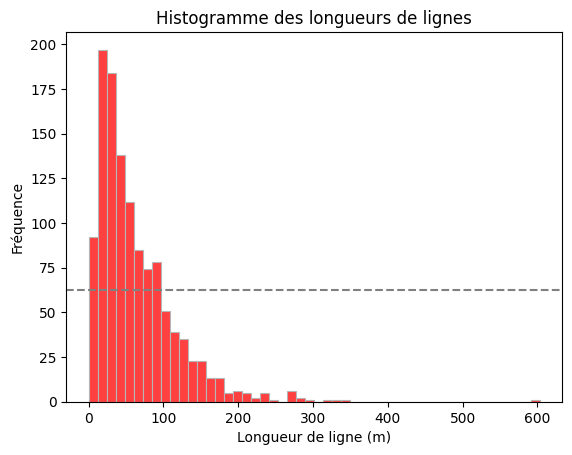

In [ ]:
# Convertir le GeoDataFrame en une projection appropriée pour le calcul de longueur
H_bdtopo2154 = H_bdtopo.to_crs(2154)

# Calculer la longueur de chaque ligne et ajouter le résultat à une nouvelle colonne
H_bdtopo2154 = H_bdtopo2154.assign(longueur=H_bdtopo2154.geometry.length)

# Calculer la somme des longueurs de toutes les lignes
longueur_totale_bdtopo = H_bdtopo2154.longueur.sum()

# Créer un histogramme des longueurs de lignes
sb.histplot(H_bdtopo2154.longueur, bins=50, edgecolor= '#b6b6b6', linewidth=0.8, color = 'red')
plt.xlabel('Longueur de ligne (m)')
plt.ylabel('Fréquence')
plt.title('Histogramme des longueurs de lignes')
# Calculer la moyenne des longueurs de haies
moyenne = H_bdtopo2154['longueur'].mean()

# Ajouter la courbe de la moyenne
plt.axhline(y=moyenne, color='grey', linestyle='--', label='Moyenne')


plt.show()


On va ensuite regarder les intersections entre les deux bases

Le nombre d'intersections entre H_osm2154 et H_bdtopo2154 est de 230


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


<Axes: >

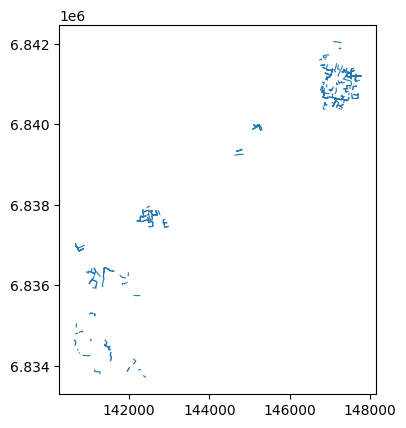

In [ ]:
# Effectuer une jointure spatiale entre H_osm2154 et H_bdtopo2154
intersections = gpd.sjoin(H_osm2154, H_bdtopo2154, how='inner', op='intersects')

# Calculer le nombre d'intersections
n_intersections = len(intersections)

# Afficher le nombre d'intersections
print(f"Le nombre d'intersections entre H_osm2154 et H_bdtopo2154 est de {n_intersections}")

intersections.plot(linewidth=0.8)

 ### Analyse spatiale 🌎

#### Longueur de haies par sections cadastrales 📏

geometry          id commune  \
0  MULTIPOLYGON (((145458.201 6843785.646, 145418...  290190000A   29019   
1  MULTIPOLYGON (((145576.130 6838607.328, 145553...  29019000AB   29019   
2  MULTIPOLYGON (((145084.056 6837820.610, 145091...  29019000AC   29019   

  prefixe code     created     updated  
0     000    A  2002-05-17  2014-03-26  
1     000   AB  2002-03-28  2022-12-26  
2     000   AC  2002-03-28  2022-12-26

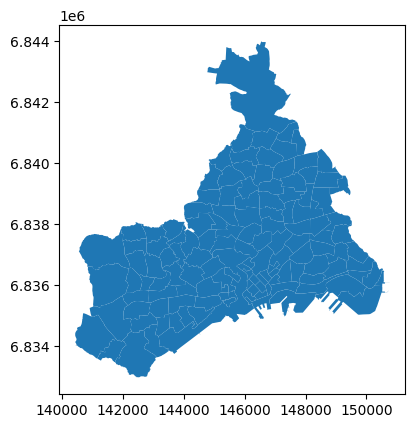

In [ ]:
#Chargement couche des Sections cadastrales

sections_commune = get_cadastre(code_insee, "sections")
sections_commune = sections_commune.to_crs(2154)
sections_commune.plot()
sections_commune.head(3)

On va par la suite calculer la longueur de ligne par sections cadastrales pour chaque jeu de données

Table OSM 🔎

In [ ]:
# Effectuer une jointure spatiale entre les haies et les sections
haies_sections1 = gpd.sjoin(H_osm2154, sections_commune, how='left', op='intersects')

# Calculer la longueur totale de haies par section
longueur_haies_par_section1 = haies_sections1.groupby('id')['longueur'].sum().reset_index()

# Fusionner les informations de longueur de haies avec les sections
sections_commune1 = sections_commune.merge(longueur_haies_par_section1, on='id', how='left')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Text(0.05, 0.98, '↑ Nord')

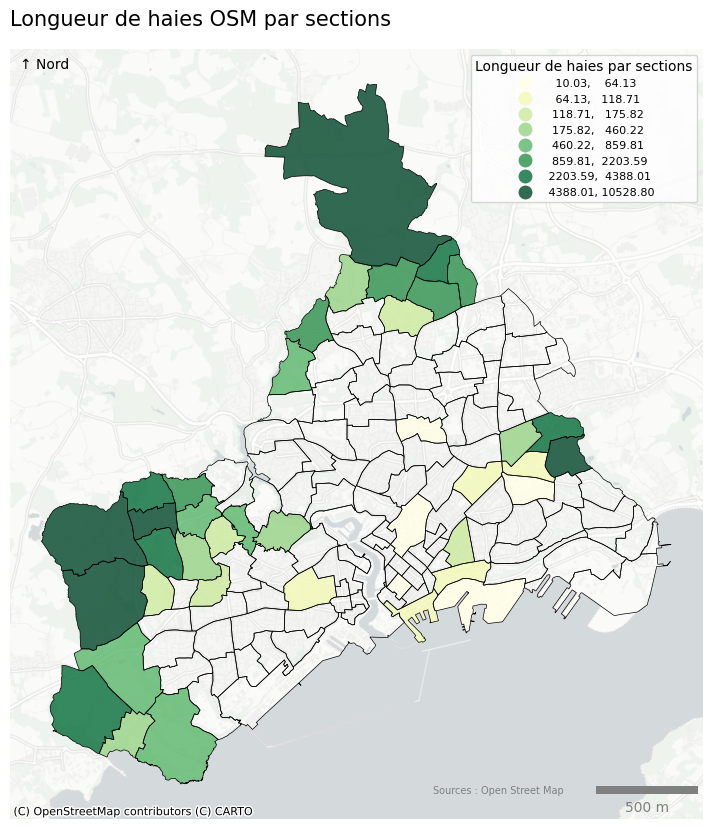

In [ ]:
# Faire la carte

Carte1, ax = plt.subplots(figsize=(10,10))

sections_commune1.to_crs('EPSG:3857').plot(ax=ax, k=8, column="longueur", cmap='YlGn',scheme='quantiles', alpha=0.8, categorical=False,
                                    legend=True, legend_kwds={'title': "Longueur de haies par sections", 'loc': 'upper right', 'title_fontsize':10, 'fontsize':8})

sections_commune1.to_crs('EPSG:3857').plot(ax=ax, color='none', edgecolor='black',linewidth=0.5)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels)
ax.axis("off")
plt.title("Longueur de haies OSM par sections", loc='left', fontsize=15)

# Ajout de l'échelle
scalebar = ScaleBar(0.2, location='lower right', box_alpha=0, color="grey")  # 1 est l'échelle, vous pouvez ajuster selon vos besoins
ax.add_artist(scalebar)

# Ajout des sources
ax.text(0.80, 0.03, 'Sources : Open Street Map', verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)

# Ajout du texte pour indiquer l'orientation
ax.text(0.05, 0.98, '↑ Nord', ha='center', va='center', fontsize=10, transform=ax.transAxes)

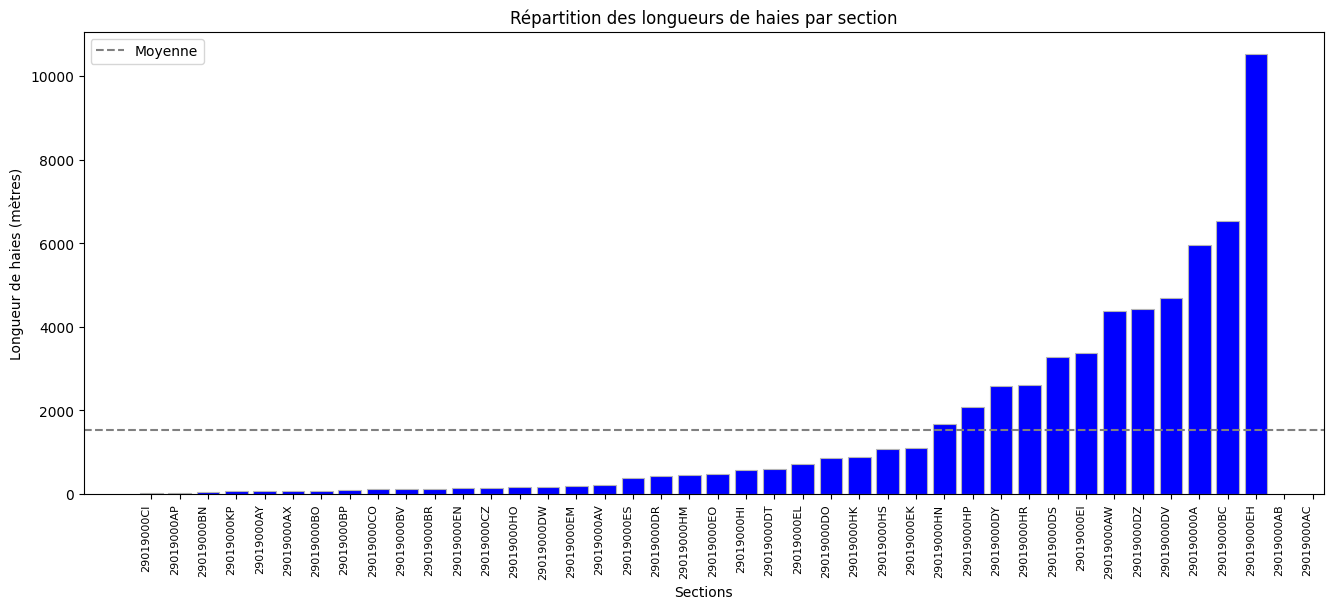

In [ ]:
# Trier les sections par longueur de haies
sections_commune1 = sections_commune1.sort_values('longueur')
# Définir la taille de la figure
plt.figure(figsize=(16,6))
# Créer un histogramme de répartition des longueurs de haies par section
plt.bar(sections_commune1['id'], sections_commune1['longueur'], edgecolor='#b6b6b6', linewidth=0.8, color = 'blue')
plt.xlabel('Sections')
plt.ylabel('Longueur de haies (mètres)')
plt.title('Répartition des longueurs de haies par section')
plt.xticks(rotation=90, ha='right', fontsize=8)

# Calculer la moyenne des longueurs de haies
moyenne = sections_commune1['longueur'].mean()

# Ajouter la courbe de la moyenne
plt.axhline(y=moyenne, color='grey', linestyle='--', label='Moyenne')

plt.legend()
plt.show()

Table BDTOPO 🧭

In [ ]:
# Effectuer une jointure spatiale entre les haies et les sections
haies_sections2 = gpd.sjoin(H_bdtopo2154, sections_commune, how='left', op='intersects')

# Calculer la longueur totale de haies par section
longueur_haies_par_section2 = haies_sections2.groupby('id_right')['longueur'].sum().reset_index()

# Fusionner les informations de longueur de haies avec les sections
sections_commune2 = sections_commune.merge(longueur_haies_par_section2, left_on='id', right_on='id_right', how='left')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Text(0.05, 0.98, '↑ Nord')

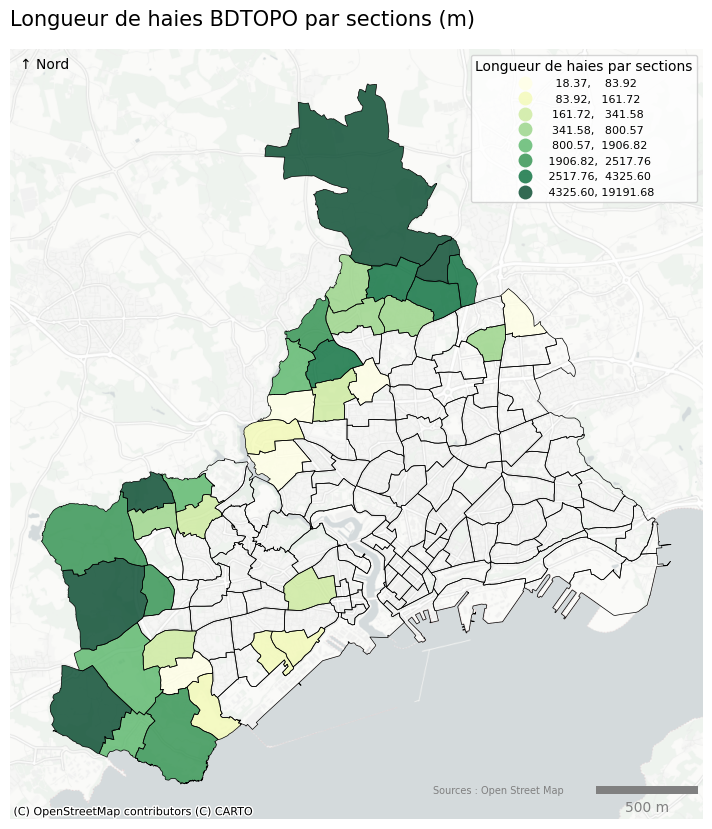

In [ ]:
# Faire la carte

Carte2, ax = plt.subplots(figsize=(10,10))

sections_commune2.to_crs('EPSG:3857').plot(ax=ax, k=8, column="longueur", cmap='YlGn',scheme='quantiles', alpha=0.8, categorical=False,
                                    legend=True, legend_kwds={'title': "Longueur de haies par sections", 'loc': 'upper right', 'title_fontsize':10, 'fontsize':8})

sections_commune2.to_crs('EPSG:3857').plot(ax=ax, color='none', edgecolor='black',linewidth=0.5)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.PositronNoLabels)
ax.axis("off")
plt.title("Longueur de haies BDTOPO par sections (m)", loc='left', fontsize=15)

# Ajout de l'échelle
scalebar = ScaleBar(0.2, location='lower right', box_alpha=0, color="grey")  # 1 est l'échelle, vous pouvez ajuster selon vos besoins
ax.add_artist(scalebar)

# Ajout des sources
ax.text(0.80, 0.03, 'Sources : Open Street Map', verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)

# Ajout du texte pour indiquer l'orientation
ax.text(0.05, 0.98, '↑ Nord', ha='center', va='center', fontsize=10, transform=ax.transAxes)

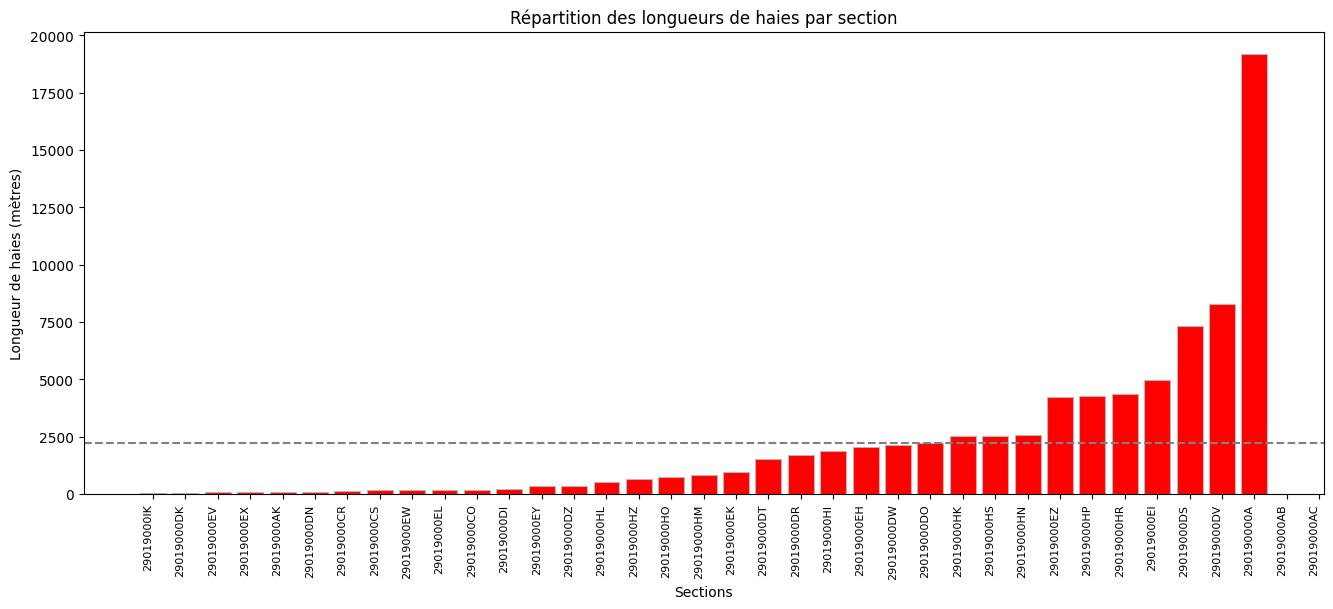

In [ ]:
# Trier les sections par longueur de haies
sections_commune2 = sections_commune2.sort_values('longueur')
# Définir la taille de la figure
plt.figure(figsize=(16,6))
# Créer un histogramme de répartition des longueurs de haies par section
plt.bar(sections_commune2['id'], sections_commune2['longueur'], edgecolor='#b6b6b6', linewidth=0.8, color = 'red')
plt.xlabel('Sections')
plt.ylabel('Longueur de haies (mètres)')
plt.title('Répartition des longueurs de haies par section')
plt.xticks(rotation=90, ha='right', fontsize=8)

# Calculer la moyenne des longueurs de haies
moyenne = sections_commune2['longueur'].mean()
# Calculer la médiane des longueurs de haies

# Ajouter la courbe de la moyenne
plt.axhline(y=moyenne, color='grey', linestyle='--', label='Moyenne')
plt.show()

## 3. Polygones : exemples des parkings

#### 🎯 Choisir la commune d'étude

In [ ]:
code_insee = 29019
name = "parkings"

# Get bdtop data
print("Fetching IGN data...")
data_bdtopo = get_bdtopo(theme=name, code_insee=code_insee)
print("Fetching OSM data...")
data_osm = get_osm(theme=name, code_insee=code_insee)
data_osm.plot

Fetching IGN data...
[Execution time: 1.9359 seconds]
Fetching OSM data...
[Execution time: 1.8124 seconds]


##### 📍 Afficher la localisation des polygones issus d'OSM et de l'IGN

<ipython-input-50-0edef95a22e2>:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


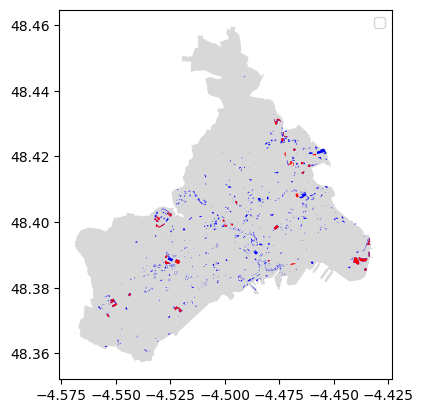

In [ ]:
# Afficher la localisation des parkings entre les deux bases

com = get_cadastre(code_insee, "communes")

_, ax = plt.subplots(nrows=1, ncols=1)
com.plot(ax=ax, color="Grey", alpha=0.3, zorder = 1)
data_bdtopo.plot(ax=ax, color="Red", label="IGN", zorder = 3)
data_osm.plot(ax=ax, color="Blue", label="OSM", zorder = 2)
plt.legend()
plt.show()


data_osm.to_file("PK_osm", layer='data_osm', driver="GPKG")
data_bdtopo.to_file("PK_bdtopo", layer='data_bdtopo', driver='GPKG')

PK_osm = data_osm
PK_bdtopo = data_bdtopo

### 🔎 **Analyses descriptives**

#### 🕛 Poids des données

In [ ]:
# Mesurer la taille (arrondi) de la liste en mémoire
#OSM
taille = sys.getsizeof(PK_osm)
print("Taille du fichier parkings en mémoire depuis OSM :", round(taille/1048576,2), "Mo")

#BD TOPO
taille = sys.getsizeof(PK_bdtopo)
print("Taille du fichier parkings en mémoire depuis la BD TOPO :", round(taille/1048576,2), "Mo")

Taille du fichier parkings en mémoire depuis OSM : 1.76 Mo
Taille du fichier parkings en mémoire depuis la BD TOPO : 0.13 Mo


###### 🧐 Les données depuis OSM sont quinze fois plus lourdes que celles de la BD TOPO

#### 📈 **Analyse attributaire**

In [ ]:
# Nombre de variables OSM
cols_osm = len(PK_osm.axes[1])
print(cols_osm)

59


In [ ]:
# Checker les types des champs des données OSM
PK_osm.dtypes

geometry                  geometry
access                      object
amenity                     object
fee                         object
parking                     object
capacity:disabled           object
source                      object
brand                       object
brand:wikidata              object
brand:wikipedia             object
name                        object
opening_hours               object
operator                    object
operator:wikidata           object
operator:wikipedia          object
name:br                     object
old_name                    object
parking:ticket:zone         object
wheelchair                  object
created_by                  object
capacity                    object
layer                       object
supervised                  object
surface                     object
source:name:br              object
maxheight                   object
addr:city                   object
addr:postcode               object
addr:street         

In [ ]:
# Nombre de variables BD TOPO
cols_topo = len(PK_bdtopo.axes[1])
print(cols_topo)

25


In [ ]:
# Checker les types des champs des données BDTOPO
PK_bdtopo.dtypes

cleabs                                   object
nature                                   object
nature_detaillee                         object
toponyme                                 object
statut_du_toponyme                       object
importance                               object
numero                                   object
fictif                                     bool
etat_de_l_objet                          object
date_creation                            object
date_modification                        object
date_d_apparition                        object
date_de_confirmation                     object
sources                                  object
identifiants_sources                     object
methode_d_acquisition_planimetrique      object
precision_planimetrique                 float64
methode_d_acquisition_altimetrique       object
precision_altimetrique                  float64
identifiant_voie_ban                     object
id                                      

In [ ]:
# Ajouter un nouveau champ ID (car il n'y a pas de valeur unique)
PK_osm['ID'] = PK_osm.index
PK_bdtopo['ID'] = PK_bdtopo.index

# Calculer le nombre de parking dans la commune depuis la base OSM
total_rows_osm = PK_osm["ID"].size

# Afficher le résultat
print("Le nombre de points de parking dans la commune de Brest dans la base OSM est de :", total_rows_osm)

# Calculer le nombre de parking dans la commune depuis la BD TOPO
total_rows_bdtopo = PK_bdtopo["ID"].size

# Afficher le résultat
print("Le nombre de parking dans la commune de Brest dans la BDTOPO est de :", total_rows_bdtopo)

Le nombre de points de parking dans la commune de Brest dans la base OSM est de : 939
Le nombre de parking dans la commune de Brest dans la BDTOPO est de : 119


##### 🥛 Taux de remplissage des attributs

In [ ]:
# Calculer le taux de remplissage des attributs pour chaque colonne OSM
tx_colomn_osm = {column: (PK_osm[column].notna().sum() / total_rows_osm) * 100 for column in PK_osm.columns}

# Trier les taux de remplissage par ordre croissant
sorted_tx_colomn_osm = sorted(tx_colomn_osm.items(), key=lambda x: x[1], reverse=True)

# Calculer le taux de remplissage total
total_non_null_osm = sum(PK_osm[column].notna().sum() for column in PK_osm.columns)
total_tx_colomn_osm = (total_non_null_osm / (total_rows_osm * len(tx_colomn_osm))) * 100

# Afficher le taux de remplissage total en première ligne en gras
print(f"\033[1mLe taux de remplissage total des attributs est de {total_tx_colomn_osm:.2f}%\033[0m")

# Afficher les taux de remplissage pour chaque colonne par ordre croissant
for column, tx_colomn_osm in sorted_tx_colomn_osm:
    print(f"'{column}' est de {tx_colomn_osm:.2f}%")

Le taux de remplissage total des attributs est de 8.58%
'geometry' est de 100.00%
'amenity' est de 100.00%
'ID' est de 100.00%
'parking' est de 63.26%
'access' est de 52.18%
'fee' est de 38.55%
'surface' est de 13.21%
'capacity' est de 9.80%
'capacity:disabled' est de 5.32%
'name' est de 4.79%
'source' est de 4.05%
'operator' est de 2.34%
'name:br' est de 1.60%
'parking:ticket:zone' est de 1.49%
'park_ride' est de 1.49%
'check_date:fee' est de 1.38%
'source:name:br' est de 1.28%
'capacity:women' est de 1.17%
'capacity:parent' est de 1.06%
'orientation' est de 1.06%
'supervised' est de 0.85%
'operator:type' est de 0.85%
'bmo:type' est de 0.75%
'parking:condition' est de 0.75%
'layer' est de 0.64%
'addr:city' est de 0.53%
'addr:postcode' est de 0.53%
'wheelchair' est de 0.43%
'opening_hours' est de 0.32%
'addr:street' est de 0.32%
'building' est de 0.32%
'parking:lane:right' est de 0.32%
'brand' est de 0.21%
'brand:wikidata' est de 0.21%
'brand:wikipedia' est de 0.21%
'operator:wikidata'

In [ ]:
# Calculer le taux de remplissage des attributs pour chaque colonne OSM
tx_colomn_osm = {column: (PK_osm[column].notna().sum() / total_rows_osm) * 100 for column in PK_osm.columns}

# Calculer le taux de remplissage médian sur l'ensemble des colonnes
median_tx_colomn_osm = np.median(list(tx_colomn_osm.values()))
# Afficher le taux de remplissage médian
print(f"\033[1mLe taux de remplissage médian des attributs est de {median_tx_colomn_osm:.2f}%\033[0m")

# Calculer le taux de remplissage minimal sur l'ensemble des colonnes
min_tx_colomn_osm = np.min(list(tx_colomn_osm.values()))
# Afficher le taux de remplissage minimal
print(f"\033[1mLe taux de remplissage minimal des attributs est de {min_tx_colomn_osm:.2f}%\033[0m")

# Calculer le taux de remplissage maximal sur l'ensemble des colonnes
max_tx_colomn_osm = np.max(list(tx_colomn_osm.values()))
# Afficher le taux de remplissage maximal
print(f"\033[1mLe taux de remplissage maximal des attributs est de {max_tx_colomn_osm:.2f}%\033[0m")

# Calculer l'écart-type du taux de remplissage sur l'ensemble des colonnes
std_tx_colomn_osm = np.std(list(tx_colomn_osm.values()))
# Afficher l'écart-type du taux de remplissage
print(f"\033[1mL'écart-type du taux de remplissage des attributs est de {std_tx_colomn_osm:.2f}%\033[0m")

Le taux de remplissage médian des attributs est de 0.32%
Le taux de remplissage minimal des attributs est de 0.11%
Le taux de remplissage maximal des attributs est de 100.00%
L'écart-type du taux de remplissage des attributs est de 23.86%


In [ ]:
# Calculer le taux de remplissage des attributs pour chaque colonne BD TOPO
tx_colomn_topo = {column: (PK_bdtopo[column].notna().sum() / total_rows_bdtopo) * 100 for column in PK_bdtopo.columns}

# Trier les taux de remplissage par ordre croissant
sorted_tx_colomn_topo = sorted(tx_colomn_topo.items(), key=lambda x: x[1], reverse = True)

# Calculer le taux de remplissage total
total_non_null_topo = sum(PK_bdtopo[column].notna().sum() for column in PK_bdtopo.columns)
total_tx_colomn_topo = (total_non_null_topo / (total_rows_bdtopo * len(tx_colomn_topo))) * 100

# Afficher le taux de remplissage total en première ligne en gras
print(f"\033[1mLe taux de remplissage total des attributs est de {total_tx_colomn_topo:.2f}%\033[0m")

# Afficher les taux de remplissage pour chaque colonne par ordre croissant
for column, tx_colomn_topo in sorted_tx_colomn_topo:
    print(f"'{column}' est de {tx_colomn_topo:.2f}%")

Le taux de remplissage total des attributs est de 66.39%
'cleabs' est de 100.00%
'nature' est de 100.00%
'fictif' est de 100.00%
'etat_de_l_objet' est de 100.00%
'date_creation' est de 100.00%
'methode_d_acquisition_planimetrique' est de 100.00%
'precision_planimetrique' est de 100.00%
'methode_d_acquisition_altimetrique' est de 100.00%
'precision_altimetrique' est de 100.00%
'id' est de 100.00%
'nom' est de 100.00%
'created' est de 100.00%
'updated' est de 100.00%
'geometry' est de 100.00%
'ID' est de 100.00%
'importance' est de 94.96%
'date_modification' est de 79.83%
'date_de_confirmation' est de 22.69%
'toponyme' est de 11.76%
'statut_du_toponyme' est de 11.76%
'nature_detaillee' est de 2.52%
'identifiant_voie_ban' est de 2.52%
'numero' est de 0.00%
'date_d_apparition' est de 0.00%
'sources' est de 0.00%
'identifiants_sources' est de 0.00%


In [ ]:
# Calculer le taux de remplissage des attributs pour chaque colonne BD TOPO
tx_colomn_topo = {column: (PK_bdtopo[column].notna().sum() / total_rows_bdtopo) * 100 for column in PK_bdtopo.columns}

# Calculer le taux de remplissage médian sur l'ensemble des colonnes
median_tx_colomn_topo = np.median(list(tx_colomn_topo.values()))
# Afficher le taux de remplissage médian
print(f"\033[1mLe taux de remplissage médian des attributs est de {median_tx_colomn_topo:.2f}%\033[0m")

# Calculer le taux de remplissage minimal sur l'ensemble des colonnes
min_tx_colomn_topo = np.min(list(tx_colomn_topo.values()))
# Afficher le taux de remplissage minimal
print(f"\033[1mLe taux de remplissage minimal des attributs est de {min_tx_colomn_topo:.2f}%\033[0m")

# Calculer le taux de remplissage maximal sur l'ensemble des colonnes
max_tx_colomn_topo = np.max(list(tx_colomn_topo.values()))
# Afficher le taux de remplissage maximal
print(f"\033[1mLe taux de remplissage maximal des attributs est de {max_tx_colomn_topo:.2f}%\033[0m")

# Calculer l'écart-type du taux de remplissage sur l'ensemble des colonnes
std_tx_colomn_topo = np.std(list(tx_colomn_topo.values()))
# Afficher l'écart-type du taux de remplissage
print(f"\033[1mL'écart-type du taux de remplissage des attributs est de {std_tx_colomn_topo:.2f}%\033[0m")

Le taux de remplissage médian des attributs est de 100.00%
Le taux de remplissage minimal des attributs est de 0.00%
Le taux de remplissage maximal des attributs est de 100.00%
L'écart-type du taux de remplissage des attributs est de 44.55%


In [ ]:
# Afficher la différence du nombre d'entités
difference = total_rows_osm - total_rows_bdtopo

print(f"\033[1mLa différence du nombre de points entre OSM et BDTOPO est de {difference} points.\033[0m")

La différence du nombre de points entre OSM et BDTOPO est de 820 points.


### 🗺️ **Analyses spatiales**

##### ❌ Y-a-t'il des erreurs topologiques ?

In [ ]:
# Reprojeter les couches en 2154
PK_osm_ok = PK_osm.to_crs(2154)
PK_bdtopo_ok = PK_bdtopo.to_crs(2154)
com_ok = com.to_crs(2154)

In [ ]:
#Caluler les erreurs topologiques pour OSM

# on aurait pu utiliser geopandas-topological-accuracy mais celui-ci n'est pas disponible via PyPI

# Vérifier la validité topologique des géométries
valid_osm = PK_osm_ok.is_valid

# Si des géométries sont invalides, on les fusionne
if not valid_osm.all():
    invalid_geoms_osm = PK_osm_ok[~valid].geometry
    merged_geom_osm = unary_union(invalid_geoms_osm)

    # Convertir la géométrie fusionnée en polygones
    if merged_geom_osm.geom_type == 'MultiPolygon':
        merged_geom = list(merged_geom_osm)
    else:
        merged_geom_osm = [merged_geom_osm]

    # Créer un GeoDataFrame à partir des polygones fusionnés
    merged_PK_osm_ok = gpd.GeoDataFrame(geometry=merged_geom_osm, crs=PK_osm_ok.crs)

    # Remplacer les géométries invalides par les polygones fusionnés
    PK_osm_ok.loc[~valid, 'geometry'] = merged_PK_osm_ok.geometry

# Calculer le nombre d'erreurs topologiques
errors_count_osm = len(PK_osm_ok) - PK_osm_ok.is_valid.sum()

print("Nombre d'erreurs topologiques pour la base OSM est de :", errors_count_osm)

Nombre d'erreurs topologiques pour la base OSM est de : 0


In [ ]:
# Vérifier la validité topologique des géométries pour la BD TOPO
valid_topo = PK_bdtopo_ok.is_valid

# Si des géométries sont invalides, tenter de les corriger
if not valid_topo.all():
    # Fusionner les géométries invalides pour créer une seule géométrie
    invalid_geoms_topo = PK_bdtopo_ok[~valid].geometry
    merged_geom_topo = unary_union(invalid_geoms_topo)

    # Convertir la géométrie fusionnée en polygones
    if merged_geom_topo.geom_type == 'MultiPolygon':
        merged_geom = list(merged_geom_topo)
    else:
        merged_geom_topo = [merged_geom_topo]

    # Créer un GeoDataFrame à partir des polygones fusionnés
    merged_PK_bdtopo_ok = gpd.GeoDataFrame(geometry=merged_geom_topo, crs=PK_bdtopo_ok.crs)

    # Remplacer les géométries invalides par les polygones fusionnés
    PK_bdtopo_ok.loc[~valid, 'geometry'] = merged_PK_bdtopo_ok.geometry

# Calculer le nombre d'erreurs topologiques
errors_count_topo = len(PK_bdtopo_ok) - PK_bdtopo_ok.is_valid.sum()

print("Nombre d'erreurs topologiques pour la base BD TOPO est de :", errors_count_topo)

Nombre d'erreurs topologiques pour la base BD TOPO est de : 0


🧐 Le nombre d'erreur topologique est égal à 0 pour les deux sources de données

##### 📥 Importation des données via cadastre.data.gouv.fr

geometry          id commune  \
0  MULTIPOLYGON (((145458.201 6843785.646, 145418...  290190000A   29019   
1  MULTIPOLYGON (((145576.130 6838607.328, 145553...  29019000AB   29019   
2  MULTIPOLYGON (((145084.056 6837820.610, 145091...  29019000AC   29019   

  prefixe code     created     updated  
0     000    A  2002-05-17  2014-03-26  
1     000   AB  2002-03-28  2022-12-26  
2     000   AC  2002-03-28  2022-12-26

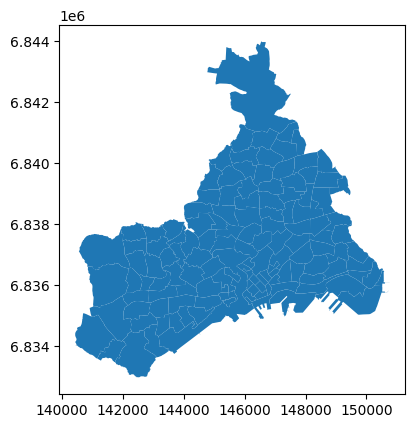

In [ ]:
#Chargement couche des Sections cadastrales

Sections = get_cadastre(code_insee, "sections")
Sections = Sections.to_crs(2154)
Sections.plot()
Sections.sindex
Sections.head(3)

##### ➕ Ajouter un champ surface aux sections cadastrales

In [ ]:
#Ajouter un champ surface dans la couche des sections cadastrales
Sections['surface'] = Sections.geometry.area

# Arrondir les valeurs de la colonne 'surface' à l'entier
Sections['surface'] = Sections['surface'].round()

##### 📐 Calculer les surfaces des parkings entre la BDTOPO et OSM

In [ ]:
# OSM
print(
  "La surface totale des polygones issus d'OSM est de "
  f"{np.sum(PK_osm_ok.geometry.area):_.2f} m²"
)
print(
  "La surface totale des polygones issus de la BD TOPO est de "
  f"{np.sum(PK_bdtopo_ok.geometry.area):_.2f} m²"
)


La surface totale des polygones issus d'OSM est de 1_069_045.59 m²
La surface totale des polygones issus de la BD TOPO est de 320_121.90 m²


In [ ]:
# OSM
PK_osm_ok['SURFACE_o'] = PK_osm_ok.geometry.area

# BD TOPO
PK_bdtopo_ok['SURFACE_b'] = PK_bdtopo_ok.geometry.area

🧐 La somme des surfaces des parkings depuis la BD TOPO est quasiment trois fois moins élevée que depuis les données OSM

#### 🔵 🔴 **Nombre de parkings par section cadastrale**

##### 🔵 Compter le nombre de parkings OSM par section cadastrale

<Axes: >

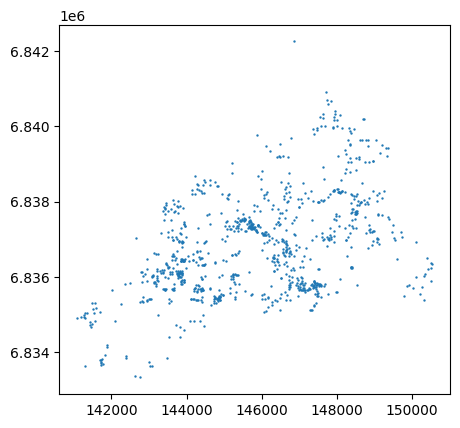

In [ ]:
#Transformer les parkings OSM (polygones) en points (centroides)
# Eviter qu'un parking soit coupé par deux sections

PK_osm_Centro = PK_osm_ok.copy()
PK_osm_Centro.geometry = PK_osm_Centro['geometry'].centroid
PK_osm_Centro.plot( markersize=0.5, legend=True)

In [ ]:
# Encrichir les parkings OSM des informations de la couche des Sections Cadastrales (jointure spatiale)

PK_osm_Etape1 = gpd.sjoin(Sections, PK_osm_Centro)
PK_osm_Etape1.head(5)

NameError: name 'PK_osm_Centro' is not defined

In [ ]:
# Encrichir les parkings OSM des informations de la couche des Sections Cadastrales (jointure spatiale)

PK_osm_Etape1 = gpd.sjoin(PK_osm_Centro, Sections)
PK_osm_Etape1.head(5)

In [ ]:
PK_osm_Etape1.plot()

###### 📏 Créer des indicateurs

In [ ]:
# Calculer le nombre de parkings OSM par sections cadastrale

NbPK_osm_Section = PK_osm_Etape1[["id", "ID"]].groupby("id").size()
NbPK_osm_Section = pd.DataFrame(NbPK_osm_Section)
NbPK_osm_Section = NbPK_osm_Section.rename(columns={0: 'NbParkings_o'})

# Afficher le résultat par ordre décroissant
NbPK_osm_Section = NbPK_osm_Section.sort_values(by='NbParkings_o', ascending=False)
NbPK_osm_Section.head(5)

In [ ]:
# Compter le nombre de parkings OSM (vérification)

total1 = PK_osm['geometry'].count()
total2 = NbPK_osm_Section['NbParkings_o'].sum()
print(total1)
print(total2)

In [ ]:
##MEAN
# Calculer la surface moyenne des parkings par section cadastrale :
surf_mean_PK_section = PK_osm_Etape1.groupby("id")["SURFACE_o"].mean()

# Convertir en DataFrame et renommer la colonne
surf_mean_PK_section = pd.DataFrame(surf_mean_PK_section)
surf_mean_PK_section = surf_mean_PK_section.rename(columns={"SURFACE_o": "SurfMoyenne_o"})

In [ ]:
##MIN
#calculer la surface minimale des parkings par section cadastrale :
surf_min_PK_section = PK_osm_Etape1.groupby("id")["SURFACE_o"].min()

# Convertir en DataFrame et renommer la colonne
surf_min_PK_section = pd.DataFrame(surf_min_PK_section)
surf_min_PK_section = surf_min_PK_section.rename(columns={"SURFACE_o": "SurfMin_o"})

In [ ]:
##MAX
#calculer la surface maximale des parkings par section cadastrale :
surf_max_PK_section = PK_osm_Etape1.groupby("id")["SURFACE_o"].max()

# Convertir en DataFrame et renommer la colonne
surf_max_PK_section = pd.DataFrame(surf_max_PK_section)
surf_max_PK_section = surf_max_PK_section.rename(columns={"SURFACE_o": "SurfMax_o"})

In [ ]:
##ECART-TYPE
#calculer l'écart-type des surfaces des parkings par section cadastrale :
surf_ect_PK_section = PK_osm_Etape1.groupby("id")["SURFACE_o"].std()

# Convertir en DataFrame et renommer la colonne
surf_ect_PK_section = pd.DataFrame(surf_ect_PK_section)
surf_ect_PK_section = surf_ect_PK_section.rename(columns={"SURFACE_o": "SurfEcT_o"})

In [ ]:
##MEDIAN
#calculer la surface médiane des parkings par section cadastrale :
surf_median_PK_section = PK_osm_Etape1.groupby("id")["SURFACE_o"].median()

# Convertir en DataFrame et renommer la colonne
surf_median_PK_section = pd.DataFrame(surf_median_PK_section)
surf_median_PK_section = surf_median_PK_section.rename(columns={"SURFACE_o": "SurfMedian_o"})

In [ ]:
##SUM
#calculer la somme des surface des parkings par section cadastrale :
surf_sum_PK_section = PK_osm_Etape1.groupby("id")["SURFACE_o"].sum()

# Convertir en DataFrame et renommer la colonne
surf_sum_PK_section = pd.DataFrame(surf_sum_PK_section)
surf_sum_PK_section = surf_sum_PK_section.rename(columns={"SURFACE_o": "SurfSum_o"})
surf_sum_PK_section.head(3)

###### 🧩 Fusionner les données OSM pour créer une cartographie

In [ ]:
# Jointure attributaire pour rapatrier les nouvelles colonnes dans la couche des centroïdes

PK_osm_Etape1 = Sections.merge(NbPK_osm_Section,on='id')\
.merge(surf_mean_PK_section,on='id')\
.merge(surf_min_PK_section,on='id')\
.merge(surf_max_PK_section,on='id')\
.merge(surf_ect_PK_section,on='id')\
.merge(surf_median_PK_section,on='id')\
.merge(surf_sum_PK_section,on='id')
PK_osm_Etape1.head(10)

In [ ]:
somme_PK_osm_Etape1 = PK_osm_Etape1['NbParkings_o'].sum()
print(somme_PK_osm_Etape1)

In [ ]:
# Créer un histogramme du nombre de parkings par section cadastrale
sb.histplot(PK_osm_Etape1.NbParkings_o, bins=50, edgecolor= '#b6b6b6', linewidth=0.8, color = 'blue')
plt.xlabel('Nombre de parkings')
plt.ylabel('Sections')
plt.title('Histogramme du nombre de parkings OSM par section cadastrale')

# Calculer la moyenne du nombre de parkings par section cadastrale
PK_moyenne_o = PK_osm_Etape1['NbParkings_o'].mean()

# Calculer la médiane du nombre de parkings par section cadastrale
PK_median_o = PK_osm_Etape1['NbParkings_o'].median()

# Ajouter la courbe de la moyenne et de la médiane
plt.axhline(y=PK_moyenne_o, color='grey', linestyle='--', label='Moyenne')
plt.axhline(y=PK_median_o, color='black', linestyle='-', label='Medianne')

plt.show()

In [ ]:
PK_osm_Etape1.sindex

In [ ]:
#Cartographier le nombre de parkings par sections cadastrales

PK_osm_Etape1 = PK_osm_Etape1.copy()
PK_osm_Etape1.geometry = PK_osm_Etape1['geometry'].centroid

sizes = PK_osm_Etape1['NbParkings_o'] *9 # Ajustez le facteur multiplicatif selon vos besoins


Carte1, ax = plt.subplots(figsize=(10,10))

Sections.to_crs('EPSG:3857').plot(ax=ax, color='none', edgecolor='grey',linewidth=0.6)
PK_osm_Etape1.to_crs('EPSG:3857').plot(ax=ax, markersize=sizes, column="SurfSum_o",cmap='YlOrRd',scheme='quantiles', alpha=0.7, legend=True)
ctx.add_basemap(ax,  source=ctx.providers.CartoDB.PositronNoLabels)

# Ajouter un titre
plt.title("Nombre et surface (m²) totale des parkings OSM", loc='left', fontsize=15, fontweight='bold')

ax.axis("off")

# Ajouter une échelle
scalebar = ScaleBar(0.2, location='lower right', box_alpha=0, color="grey")  # 1 est l'échelle, vous pouvez ajuster selon vos besoins
ax.add_artist(scalebar)

# Ajout des sources
ax.text(0.80, 0.03, 'Sources : Open Street Map', verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)

# Ajout du texte pour indiquer l'orientation
ax.text(0.95, 0.83, '↑ Nord', ha='center', va='center', fontsize=10, transform=ax.transAxes)

# Ajout du sous-titre
plt.text(0.25, 0.97, "Nombre de parkings compris entre {} et {} \n par section cadastrale".format(min(NbPK_osm_Section['NbParkings_o']), max(NbPK_osm_Section['NbParkings_o'])), fontsize=11, ha='center', va='center', transform=ax.transAxes)


plt.show()

##### 🔴 Compter le nombre de parkings de la BD TOPO par section cadastrale

<Axes: >

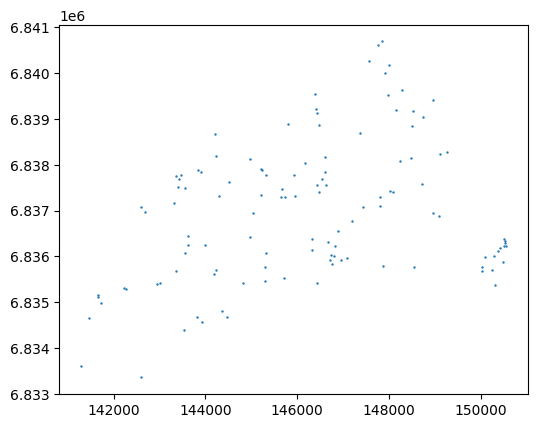

In [ ]:
#Transformer les parkings BD TOPO (polygones) en points (centroides)
# Eviter qu'un parking soit coupé par deux sections

PK_topo_Centro = PK_bdtopo_ok.copy()
PK_topo_Centro.geometry = PK_topo_Centro['geometry'].centroid
PK_topo_Centro.plot( markersize=0.5, legend=True)

In [ ]:
# Encrichir les parkings BD TOPO des informations de la couche des Sections Cadastrales (jointure spatiale)

PK_topo_Etape1 = gpd.sjoin(PK_topo_Centro, Sections)
PK_topo_Etape1.head(5)

cleabs   nature nature_detaillee toponyme  \
0   EQ_RESEA0000000130200516  Parking             None     None   
5   EQ_RESEA0000000130200532  Parking             None     None   
7   EQ_RESEA0000000130200542  Parking             None     None   
73  EQ_RESEA0000000130186865  Parking             None     None   
1   EQ_RESEA0000000130200519  Parking             None     None   

   statut_du_toponyme importance numero  fictif etat_de_l_objet  \
0                None          5   None    True      En service   
5                None          5   None    True      En service   
7                None          5   None    True      En service   
73               None          5   None    True      En service   
1                None          5   None    True      En service   

               date_creation  ...  ID  SURFACE_b index_right    id_right  \
0   2008-05-26T07:44:22.810Z  ...   0  24.952116          38  29019000BY   
5   2008-05-26T07:44:22.810Z  ...   5  25.034401          38  29019000BY   
7   2008-05-26T07:44:22.810Z  ...   7  25.202481          38  29019000BY   
73  2008-05-26T07:05:44.822Z  ...  73  25.035076          38  29019000BY   
1   2008-05-26T07:44:22.810Z  ...   1  24.993393           9  29019000AM   

   commune prefixe  code created_right  updated_right   surface  
0    29019     000    BY    2002-03-28     2015-08-13  291802.0  
5    29019     000    BY    2002-03-28     2015-08-13  291802.0  
7    29019     000    BY    2002-03-28     2015-08-13  291802.0  
73   29019     000    BY    2002-03-28     2015-08-13  291802.0  
1    29019     000    AM    2002-03-28     2020-06-11  336937.0  

[5 rows x 35 columns]

###### 📏 Créer des indicateurs

In [ ]:
# Calculer le nombre de parkings BD TOPO par sections cadastrale

NbPK_topo_Section = PK_topo_Etape1[["id_right"]].groupby("id_right").size()
NbPK_topo_Section = pd.DataFrame(NbPK_topo_Section)
NbPK_topo_Section = NbPK_topo_Section.rename(columns={0: 'NbParkings_b'})

# Afficher le résultat dans l'ordre décroissant
NbPK_topo_Section = NbPK_topo_Section.sort_values(by='NbParkings_b', ascending=False)
NbPK_topo_Section.head(5)

NbParkings_b
id_right                
29019000KX             8
29019000KZ             5
29019000KY             5
29019000BY             4
29019000KN             4

In [ ]:
# Compter le nombre de parkings BD TOPO (vérification)

total1_topo = PK_bdtopo['geometry'].count()
total2_topo = NbPK_topo_Section['NbParkings_b'].sum()
print(total1_topo)
print(total2_topo)

119
119


In [ ]:
##MEAN
# Calculer la surface moyenne des parkings par section cadastrale :
surf_mean_PK_section_t = PK_topo_Etape1.groupby("id_right")["SURFACE_b"].mean()

# Convertir en DataFrame et renommer la colonne
surf_mean_PK_section_t = pd.DataFrame(surf_mean_PK_section_t)
surf_mean_PK_section_t = surf_mean_PK_section_t.rename(columns={"SURFACE_b": "SurfMoyenne_b"})

In [ ]:
##MIN
#calculer la surface minimale des parkings par section cadastrale :
surf_min_PK_section_t = PK_topo_Etape1.groupby("id_right")["SURFACE_b"].min()

# Convertir en DataFrame et renommer la colonne
surf_min_PK_section_t = pd.DataFrame(surf_min_PK_section_t)
surf_min_PK_section_t = surf_min_PK_section_t.rename(columns={"SURFACE_b": "SurfMin_b"})

In [ ]:
##MAX
#calculer la surface maximale des parkings par section cadastrale :
surf_max_PK_section_t = PK_topo_Etape1.groupby("id_right")["SURFACE_b"].max()

# Convertir en DataFrame et renommer la colonne
surf_max_PK_section_t = pd.DataFrame(surf_max_PK_section_t)
surf_max_PK_section_t = surf_max_PK_section_t.rename(columns={"SURFACE_b": "SurfMax_b"})

In [ ]:
##ECART-TYPE
#calculer l'écart-type des surfaces des parkings par section cadastrale :
surf_ect_PK_section_t = PK_topo_Etape1.groupby("id_right")["SURFACE_b"].std()

# Convertir en DataFrame et renommer la colonne
surf_ect_PK_section_t = pd.DataFrame(surf_ect_PK_section_t)
surf_ect_PK_section_t = surf_ect_PK_section_t.rename(columns={"SURFACE_b": "SurfEcT_b"})

In [ ]:
##MEDIAN
#calculer la surface médiane des parkings par section cadastrale :
surf_median_PK_section_t = PK_topo_Etape1.groupby("id_right")["SURFACE_b"].median()

# Convertir en DataFrame et renommer la colonne
surf_median_PK_section_t = pd.DataFrame(surf_median_PK_section_t)
surf_median_PK_section_t = surf_median_PK_section_t.rename(columns={"SURFACE_b": "SurfMedian_b"})

In [ ]:
##SUM
#calculer la somme des surface des parkings par section cadastrale :
surf_sum_PK_section_t = PK_topo_Etape1.groupby("id_right")["SURFACE_b"].sum()

# Convertir en DataFrame et renommer la colonne
surf_sum_PK_section_t = pd.DataFrame(surf_sum_PK_section_t)
surf_sum_PK_section_t = surf_sum_PK_section_t.rename(columns={"SURFACE_b": "SurfSum_b"})
surf_sum_PK_section_t.head(3)

SurfSum_b
id_right             
29019000AC  74.536196
29019000AD  24.951690
29019000AE  24.951495

###### 🧩 Fusionner les données BD TOPO pour créer une cartographie

In [ ]:
Sections.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  133 non-null    geometry
 1   id        133 non-null    object  
 2   commune   133 non-null    object  
 3   prefixe   133 non-null    object  
 4   code      133 non-null    object  
 5   created   133 non-null    object  
 6   updated   133 non-null    object  
 7   surface   133 non-null    float64 
dtypes: float64(1), geometry(1), object(6)
memory usage: 8.4+ KB


In [ ]:
# Jointure attributaire pour rapatrier les nouvelles colonnes dans la couche des centroïdes
Sections = Sections.rename(columns={"id":"id_right"})

PK_topo_Etape1 = Sections.merge(NbPK_topo_Section, on='id_right')\
.merge(surf_mean_PK_section_t,on='id_right')\
.merge(surf_min_PK_section_t,on='id_right')\
.merge(surf_max_PK_section_t,on='id_right')\
.merge(surf_ect_PK_section_t,on='id_right')\
.merge(surf_median_PK_section_t,on='id_right')\
.merge(surf_sum_PK_section_t,on='id_right')
PK_topo_Etape1.head(10)

geometry    id_right commune  \
0  MULTIPOLYGON (((145084.056 6837820.610, 145091...  29019000AC   29019   
1  MULTIPOLYGON (((145769.069 6837931.171, 145748...  29019000AD   29019   
2  MULTIPOLYGON (((145987.547 6837862.238, 145864...  29019000AE   29019   
3  MULTIPOLYGON (((145780.899 6838479.843, 145782...  29019000AH   29019   
4  MULTIPOLYGON (((145903.316 6838887.788, 145895...  29019000AI   29019   
5  MULTIPOLYGON (((145916.646 6839327.342, 145917...  29019000AK   29019   
6  MULTIPOLYGON (((146391.262 6839931.322, 146390...  29019000AM   29019   
7  MULTIPOLYGON (((147620.596 6838785.420, 147539...  29019000AR   29019   
8  MULTIPOLYGON (((148756.214 6838163.646, 148730...  29019000AV   29019   
9  MULTIPOLYGON (((149117.740 6838338.299, 149115...  29019000AW   29019   

  prefixe code     created     updated   surface  NbParkings_b  SurfMoyenne_b  \
0     000   AC  2002-03-28  2022-12-26  211830.0             3      24.845399   
1     000   AD  2002-03-29  2015-08-13  263485.0             1      24.951690   
2     000   AE  2002-03-28  2023-05-23  324183.0             1      24.951495   
3     000   AH  2002-03-28  2015-08-13  449193.0             1    5262.914177   
4     000   AI  2018-11-14  2018-11-14  345967.0             2      24.870799   
5     000   AK  2002-03-28  2015-08-13  280791.0             2      25.071019   
6     000   AM  2002-03-28  2020-06-11  336937.0             1      24.993393   
7     000   AR  2002-03-28  2019-09-30  229122.0             1      25.198028   
8     000   AV  2002-03-28  2015-08-13  299415.0             2    4920.571289   
9     000   AW  2002-03-28  2015-08-13  319306.0             2      24.948240   

     SurfMin_b    SurfMax_b    SurfEcT_b  SurfMedian_b    SurfSum_b  
0    24.749711    25.000597     0.135618     24.785887    74.536196  
1    24.951690    24.951690          NaN     24.951690    24.951690  
2    24.951495    24.951495          NaN     24.951495    24.951495  
3  5262.914177  5262.914177          NaN   5262.914177  5262.914177  
4    24.745455    24.996143     0.177264     24.870799    49.741598  
5    24.945383    25.196654     0.177675     25.071019    50.142038  
6    24.993393    24.993393          NaN     24.993393    24.993393  
7    25.198028    25.198028          NaN     25.198028    25.198028  
8    25.199840  9815.942738  6923.100696   4920.571289  9841.142578  
9    24.948140    24.948341     0.000142     24.948240    49.896480

In [ ]:
somme_PK_topo_Etape1 = PK_topo_Etape1['NbParkings_b'].sum()
print(somme_PK_topo_Etape1)

119


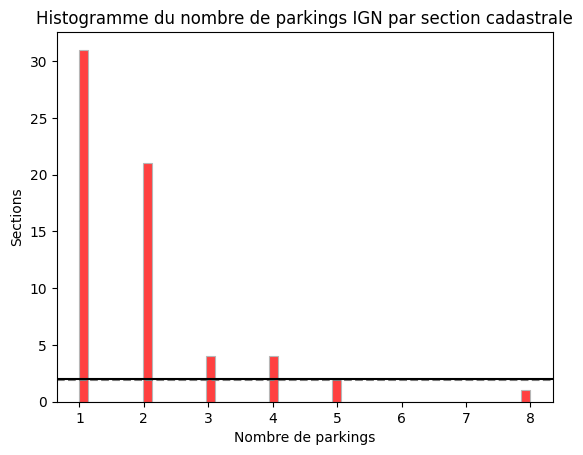

In [ ]:
# Créer un histogramme du nombre de parkings par section cadastrale
sb.histplot(PK_topo_Etape1.NbParkings_b, bins=50, edgecolor= '#b6b6b6', linewidth=0.8, color = 'red')
plt.xlabel('Nombre de parkings')
plt.ylabel('Sections')
plt.title('Histogramme du nombre de parkings IGN par section cadastrale')

# Calculer la moyenne du nombre de parkings par section cadastrale
PK_moyenne_b = PK_topo_Etape1['NbParkings_b'].mean()

# Calculer la médiane du nombre de parkings par section cadastrale
PK_median_b = PK_topo_Etape1['NbParkings_b'].median()

# Ajouter la courbe de la moyenne et de la médiane
plt.axhline(y=PK_moyenne_b, color='grey', linestyle='--', label='Moyenne')
plt.axhline(y=PK_median_b, color='black', linestyle='-', label='Medianne')

plt.show()

In [ ]:
PK_topo_Etape1.sindex

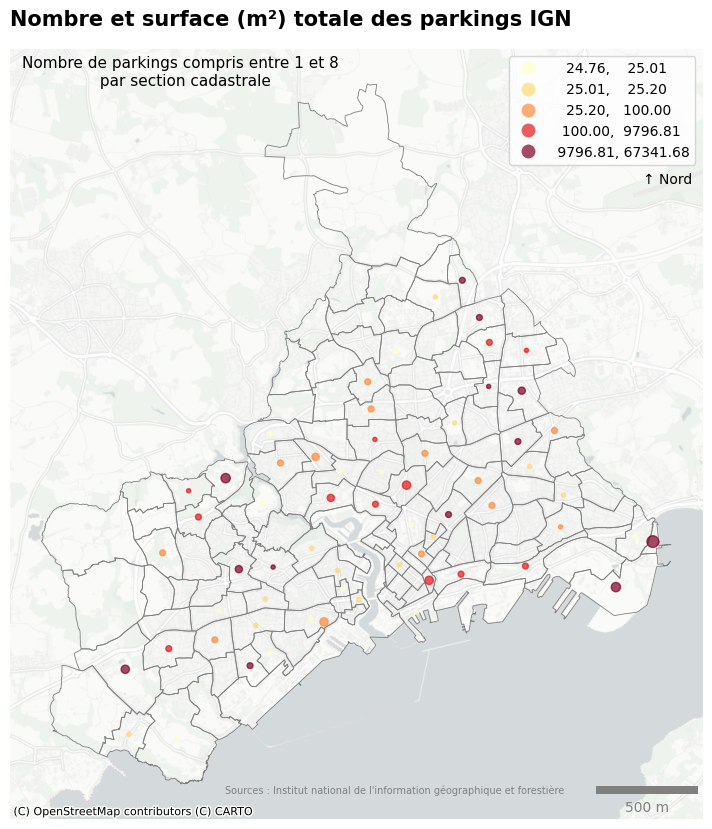

In [ ]:
#Cartographier le nombre de parkings par sections cadastrales


#Cartographier le nombre d'arbres par IRIS
PK_topo_Etape1 = PK_topo_Etape1.copy()
PK_topo_Etape1.geometry = PK_topo_Etape1['geometry'].centroid

sizes = PK_topo_Etape1['NbParkings_b'] *9 # Ajustez le facteur multiplicatif selon vos besoins


Carte2, ax = plt.subplots(figsize=(10,10))

Sections.to_crs('EPSG:3857').plot(ax=ax, color='none', edgecolor='grey',linewidth=0.6)
PK_topo_Etape1.to_crs('EPSG:3857').plot(ax=ax, markersize=sizes, column="SurfSum_b",cmap='YlOrRd',scheme='quantiles', alpha=0.7, legend=True)
ctx.add_basemap(ax,  source=ctx.providers.CartoDB.PositronNoLabels)

# Ajouter un titre
plt.title("Nombre et surface (m²) totale des parkings IGN", loc='left', fontsize=15, fontweight='bold')

ax.axis("off")

# Ajout de l'échelle
scalebar = ScaleBar(0.2, location='lower right', box_alpha=0, color="grey")  # 1 est l'échelle, vous pouvez ajuster selon vos besoins
ax.add_artist(scalebar)

# Ajout des sources
ax.text(0.80, 0.03, "Sources : Institut national de l'information géographique et forestière", verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)

# Ajout du texte pour indiquer l'orientation
ax.text(0.95, 0.83, '↑ Nord', ha='center', va='center', fontsize=10, transform=ax.transAxes)

# Ajout du sous-titre
plt.text(0.25, 0.97, "Nombre de parkings compris entre {} et {} \n par section cadastrale".format(min(NbPK_topo_Section['NbParkings_b']), max(NbPK_topo_Section['NbParkings_b']),), fontsize=11, ha='center', va='center', transform=ax.transAxes)


plt.show()

#### 🟦 🟥 **Taux de recouvrement**

##### 🟦 Taux de recouvrement OSM

In [ ]:
PK_osm_Etape1.head()

geometry          id commune prefixe code  \
0  POINT (146313.035 6842405.988)  290190000A   29019     000    A   
1  POINT (145132.909 6838045.338)  29019000AC   29019     000   AC   
2  POINT (145521.035 6837752.318)  29019000AD   29019     000   AD   
3  POINT (146176.172 6837695.065)  29019000AE   29019     000   AE   
4  POINT (146121.146 6838234.832)  29019000AH   29019     000   AH   

      created     updated    surface  NbParkings_o  SurfMoyenne_o   SurfMin_o  \
0  2002-05-17  2014-03-26  4191220.0             1     819.027582  819.027582   
1  2002-03-28  2022-12-26   211830.0             6    2369.065312  343.379475   
2  2002-03-29  2015-08-13   263485.0             6    1673.078638  473.329630   
3  2002-03-28  2023-05-23   324183.0             5     838.534729  130.884520   
4  2002-03-28  2015-08-13   449193.0             6    1359.906053  179.068916   

     SurfMax_o    SurfEcT_o  SurfMedian_o     SurfSum_o  
0   819.027582          NaN    819.027582    819.027582  
1  8008.083121  2870.322758   1612.972658  14214.391869  
2  2779.150795   829.568182   1863.356483  10038.471826  
3  1940.571140   880.592269    322.618047   4192.673643  
4  4628.848045  1708.243946    686.475306   8159.436318

In [ ]:
# Calculer le taux de recouvrement
tx_osm = round(PK_osm_Etape1['SurfSum_o']/PK_osm_Etape1['surface']*100,2)

# Créer une séie Pandas
sPK_osm_Etape1tx_osm = pd.Series(tx_osm, name='Tx_osm')

# Jointure attributaire
PK_osm_Etape1 = PK_osm_Etape1.merge(sPK_osm_Etape1tx_osm, left_index=True, right_index=True)

PK_osm_Etape1.head(5)

geometry          id commune prefixe code  \
0  POINT (146313.035 6842405.988)  290190000A   29019     000    A   
1  POINT (145132.909 6838045.338)  29019000AC   29019     000   AC   
2  POINT (145521.035 6837752.318)  29019000AD   29019     000   AD   
3  POINT (146176.172 6837695.065)  29019000AE   29019     000   AE   
4  POINT (146121.146 6838234.832)  29019000AH   29019     000   AH   

      created     updated    surface  NbParkings_o  SurfMoyenne_o   SurfMin_o  \
0  2002-05-17  2014-03-26  4191220.0             1     819.027582  819.027582   
1  2002-03-28  2022-12-26   211830.0             6    2369.065312  343.379475   
2  2002-03-29  2015-08-13   263485.0             6    1673.078638  473.329630   
3  2002-03-28  2023-05-23   324183.0             5     838.534729  130.884520   
4  2002-03-28  2015-08-13   449193.0             6    1359.906053  179.068916   

     SurfMax_o    SurfEcT_o  SurfMedian_o     SurfSum_o  Tx_osm  
0   819.027582          NaN    819.027582    819.027582    0.02  
1  8008.083121  2870.322758   1612.972658  14214.391869    6.71  
2  2779.150795   829.568182   1863.356483  10038.471826    3.81  
3  1940.571140   880.592269    322.618047   4192.673643    1.29  
4  4628.848045  1708.243946    686.475306   8159.436318    1.82

In [ ]:
# Encrichir les parkings OSM des informations de la couche des Sections Cadastrales (jointure spatiale)

Sections_reo = gpd.sjoin(Sections, PK_osm_Etape1)
Sections_reo.head(5)

geometry    id_right commune_left  \
0  MULTIPOLYGON (((145458.201 6843785.646, 145418...  290190000A        29019   
2  MULTIPOLYGON (((145084.056 6837820.610, 145091...  29019000AC        29019   
3  MULTIPOLYGON (((145769.069 6837931.171, 145748...  29019000AD        29019   
4  MULTIPOLYGON (((145987.547 6837862.238, 145864...  29019000AE        29019   
5  MULTIPOLYGON (((145780.899 6838479.843, 145782...  29019000AH        29019   

  prefixe_left code_left created_left updated_left  surface_left  index_right  \
0          000         A   2002-05-17   2014-03-26     4191220.0            0   
2          000        AC   2002-03-28   2022-12-26      211830.0            1   
3          000        AD   2002-03-29   2015-08-13      263485.0            2   
4          000        AE   2002-03-28   2023-05-23      324183.0            3   
5          000        AH   2002-03-28   2015-08-13      449193.0            4   

           id  ... updated_right surface_right NbParkings_o SurfMoyenne_o  \
0  290190000A  ...    2014-03-26     4191220.0            1    819.027582   
2  29019000AC  ...    2022-12-26      211830.0            6   2369.065312   
3  29019000AD  ...    2015-08-13      263485.0            6   1673.078638   
4  29019000AE  ...    2023-05-23      324183.0            5    838.534729   
5  29019000AH  ...    2015-08-13      449193.0            6   1359.906053   

    SurfMin_o    SurfMax_o    SurfEcT_o  SurfMedian_o     SurfSum_o  Tx_osm  
0  819.027582   819.027582          NaN    819.027582    819.027582    0.02  
2  343.379475  8008.083121  2870.322758   1612.972658  14214.391869    6.71  
3  473.329630  2779.150795   829.568182   1863.356483  10038.471826    3.81  
4  130.884520  1940.571140   880.592269    322.618047   4192.673643    1.29  
5  179.068916  4628.848045  1708.243946    686.475306   8159.436318    1.82  

[5 rows x 24 columns]

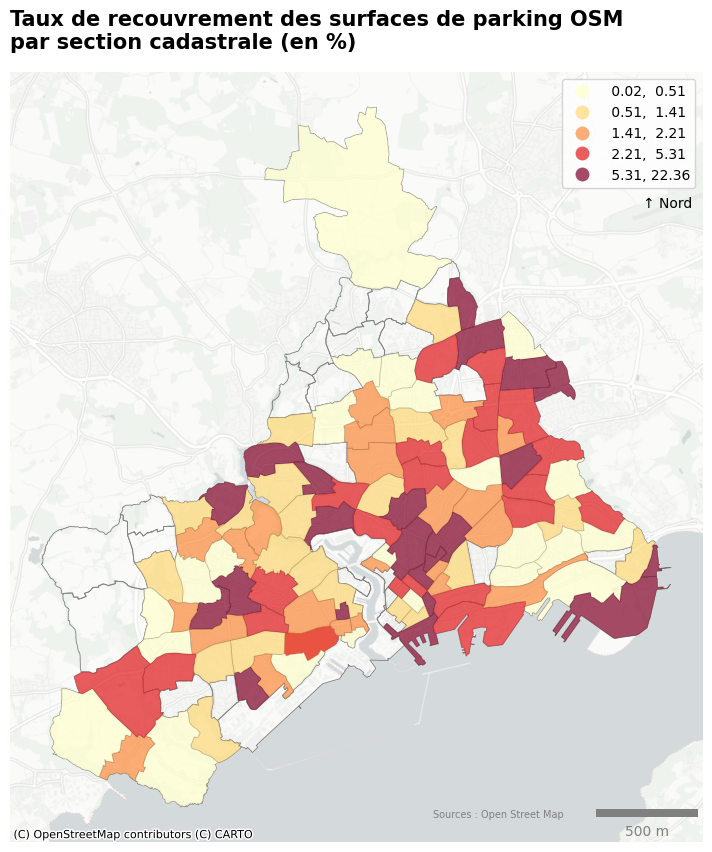

In [ ]:
#Cartographier le taux de recouvrement des surfaces de parkings par sections cadastrales

Sections = Sections.copy()
Sections.geometry = Sections['geometry']

Carte3, ax = plt.subplots(figsize=(10,10))

Sections.to_crs('EPSG:3857').plot(ax=ax, color='none', edgecolor='grey',linewidth=0.6)
Sections_reo.to_crs('EPSG:3857').plot(ax=ax, markersize=sizes, column="Tx_osm",cmap='YlOrRd',scheme='quantiles', alpha=0.7, legend=True)
ctx.add_basemap(ax,  source=ctx.providers.CartoDB.PositronNoLabels)

# Ajouter un titre
plt.title("Taux de recouvrement des surfaces de parking OSM \npar section cadastrale (en %)", loc='left', fontsize=15, fontweight='bold')

ax.axis("off")

# Ajout de l'échelle
scalebar = ScaleBar(0.2, location='lower right', box_alpha=0, color="grey")  # 1 est l'échelle, vous pouvez ajuster selon vos besoins
ax.add_artist(scalebar)

# Ajout des sources
ax.text(0.80, 0.03, 'Sources : Open Street Map', verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)

# Ajout du texte pour indiquer l'orientation
ax.text(0.95, 0.83, '↑ Nord', ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()

##### 🟥 Taux de recouvrement IGN

In [ ]:
PK_topo_Etape1.head()

geometry    id_right commune prefixe code  \
0  POINT (145132.909 6838045.338)  29019000AC   29019     000   AC   
1  POINT (145521.035 6837752.318)  29019000AD   29019     000   AD   
2  POINT (146176.172 6837695.065)  29019000AE   29019     000   AE   
3  POINT (146121.146 6838234.832)  29019000AH   29019     000   AH   
4  POINT (146105.988 6838733.831)  29019000AI   29019     000   AI   

      created     updated   surface  NbParkings_b  SurfMoyenne_b    SurfMin_b  \
0  2002-03-28  2022-12-26  211830.0             3      24.845399    24.749711   
1  2002-03-29  2015-08-13  263485.0             1      24.951690    24.951690   
2  2002-03-28  2023-05-23  324183.0             1      24.951495    24.951495   
3  2002-03-28  2015-08-13  449193.0             1    5262.914177  5262.914177   
4  2018-11-14  2018-11-14  345967.0             2      24.870799    24.745455   

     SurfMax_b  SurfEcT_b  SurfMedian_b    SurfSum_b  
0    25.000597   0.135618     24.785887    74.536196  
1    24.951690        NaN     24.951690    24.951690  
2    24.951495        NaN     24.951495    24.951495  
3  5262.914177        NaN   5262.914177  5262.914177  
4    24.996143   0.177264     24.870799    49.741598

In [ ]:
# Calculer le taux de recouvrement
tx_topo = round(PK_topo_Etape1['SurfSum_b']/PK_topo_Etape1['surface']*100,2)

# Créer une séie Pandas
sPK_topo_Etape1tx_topo = pd.Series(tx_topo, name='Tx_topo')

# Jointure attributaire
PK_topo_Etape1 = PK_topo_Etape1.merge(sPK_topo_Etape1tx_topo, left_index=True, right_index=True)

PK_topo_Etape1.head(5)

geometry    id_right commune prefixe code  \
0  POINT (145132.909 6838045.338)  29019000AC   29019     000   AC   
1  POINT (145521.035 6837752.318)  29019000AD   29019     000   AD   
2  POINT (146176.172 6837695.065)  29019000AE   29019     000   AE   
3  POINT (146121.146 6838234.832)  29019000AH   29019     000   AH   
4  POINT (146105.988 6838733.831)  29019000AI   29019     000   AI   

      created     updated   surface  NbParkings_b  SurfMoyenne_b    SurfMin_b  \
0  2002-03-28  2022-12-26  211830.0             3      24.845399    24.749711   
1  2002-03-29  2015-08-13  263485.0             1      24.951690    24.951690   
2  2002-03-28  2023-05-23  324183.0             1      24.951495    24.951495   
3  2002-03-28  2015-08-13  449193.0             1    5262.914177  5262.914177   
4  2018-11-14  2018-11-14  345967.0             2      24.870799    24.745455   

     SurfMax_b  SurfEcT_b  SurfMedian_b    SurfSum_b  Tx_topo  
0    25.000597   0.135618     24.785887    74.536196     0.04  
1    24.951690        NaN     24.951690    24.951690     0.01  
2    24.951495        NaN     24.951495    24.951495     0.01  
3  5262.914177        NaN   5262.914177  5262.914177     1.17  
4    24.996143   0.177264     24.870799    49.741598     0.01

In [ ]:
# Encrichir les parkings de la BD TOPO des informations de la couche des Sections Cadastrales (jointure spatiale)

Sections_reo = gpd.sjoin(Sections, PK_topo_Etape1)
Sections_reo.head(5)

geometry id_right_left  \
2  MULTIPOLYGON (((145084.056 6837820.610, 145091...    29019000AC   
3  MULTIPOLYGON (((145769.069 6837931.171, 145748...    29019000AD   
4  MULTIPOLYGON (((145987.547 6837862.238, 145864...    29019000AE   
5  MULTIPOLYGON (((145780.899 6838479.843, 145782...    29019000AH   
6  MULTIPOLYGON (((145903.316 6838887.788, 145895...    29019000AI   

  commune_left prefixe_left code_left created_left updated_left  surface_left  \
2        29019          000        AC   2002-03-28   2022-12-26      211830.0   
3        29019          000        AD   2002-03-29   2015-08-13      263485.0   
4        29019          000        AE   2002-03-28   2023-05-23      324183.0   
5        29019          000        AH   2002-03-28   2015-08-13      449193.0   
6        29019          000        AI   2018-11-14   2018-11-14      345967.0   

   index_right id_right_right  ... updated_right surface_right NbParkings_b  \
2            0     29019000AC  ...    2022-12-26      211830.0            3   
3            1     29019000AD  ...    2015-08-13      263485.0            1   
4            2     29019000AE  ...    2023-05-23      324183.0            1   
5            3     29019000AH  ...    2015-08-13      449193.0            1   
6            4     29019000AI  ...    2018-11-14      345967.0            2   

  SurfMoyenne_b    SurfMin_b    SurfMax_b  SurfEcT_b  SurfMedian_b  \
2     24.845399    24.749711    25.000597   0.135618     24.785887   
3     24.951690    24.951690    24.951690        NaN     24.951690   
4     24.951495    24.951495    24.951495        NaN     24.951495   
5   5262.914177  5262.914177  5262.914177        NaN   5262.914177   
6     24.870799    24.745455    24.996143   0.177264     24.870799   

     SurfSum_b  Tx_topo  
2    74.536196     0.04  
3    24.951690     0.01  
4    24.951495     0.01  
5  5262.914177     1.17  
6    49.741598     0.01  

[5 rows x 24 columns]

/usr/local/lib/python3.10/dist-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


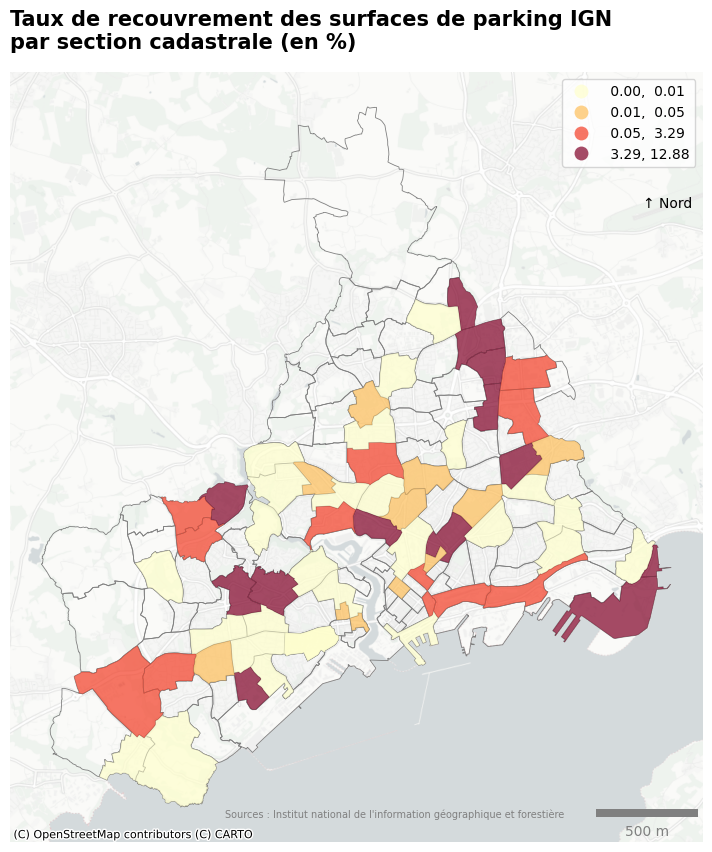

In [ ]:
#Cartographier le taux de recouvrement des surfaces de parkings par sections cadastrales

Sections = Sections.copy()
Sections.geometry = Sections['geometry']

Carte4, ax = plt.subplots(figsize=(10,10))

Sections.to_crs('EPSG:3857').plot(ax=ax, color='none', edgecolor='grey',linewidth=0.6)
Sections_reo.to_crs('EPSG:3857').plot(ax=ax, markersize=sizes, column="Tx_topo",cmap='YlOrRd',scheme='quantiles', alpha=0.7, legend=True)
ctx.add_basemap(ax,  source=ctx.providers.CartoDB.PositronNoLabels)

# Ajouter un titre
plt.title("Taux de recouvrement des surfaces de parking IGN \npar section cadastrale (en %)", loc='left', fontsize=15, fontweight='bold')

ax.axis("off")

# Ajout de l'échelle
scalebar = ScaleBar(0.2, location='lower right', box_alpha=0, color="grey")  # 1 est l'échelle, vous pouvez ajuster selon vos besoins
ax.add_artist(scalebar)

# Ajout des sources
ax.text(0.80, 0.03, "Sources : Institut national de l'information géographique et forestière", verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=7)

# Ajout du texte pour indiquer l'orientation
ax.text(0.95, 0.83, '↑ Nord', ha='center', va='center', fontsize=10, transform=ax.transAxes)

plt.show()